## Описание проекта


This project aims to predict customer churn for a telecommunications service provider and devise a retention strategy that involves offering promotional codes and special incentives to customers who are at risk of terminating their contracts.   
 The project utilizes data from different sources, including:

- `contract_new.csv`: Contract information, 7043 entries, 8 variables (customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges)
- `personal_new.csv`: Customer personal data, 7043 entries, 5 variables
- `internet_new.csv`: Internet service information, 5516 entries, 8 variables
- `phone_new.csv`: Phone service information, 6361 entries, 2 variables

In all these files, the `customerID` column contains unique customer identifiers.


### План работы

1. **Предобработка и разведовательный анализ данных**.  
Объединение таблиц, обработка пропусков, изменение типов данных.
Определение и создание целевого признака, признака длительности договора.  
Опрелеление портрета клиента, ушедшего клиента и действующнго клиента  
Просмотр динамики притока/оттока клиентов  
Определение корреляции признаков
2. **Моделирование**  
Определение необходимых признаков (во избежание мультиколинеарности)  
Разделение на тренировочную и тестовую выборки  
Кодирование (OHE) и масштабирование (через пайплайн)  
Обучение и подбор гирерпараметров на 3х моделях  
Выбор лучшей модели по кросс-валидационной метрике ROC-AUC 
3. **Тестирование**  
Проверка выбранной модели на тестовой выборке (ROC-AUC > 0.85)
4. **Исследование модели**  
Исследование важных для модели признаков  
Матрица ошибок, подбор оптимального порога вероятности.


## Предобработка данных и исследовательский анализ

In [1]:
pip install optuna -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install shap -q


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import time
import shap
shap.initjs()

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from optuna.integration import OptunaSearchCV



Сохранение датасетов

In [4]:
path_contract = 'C:/Users/Julia/Documents/Portfolio/16_customer_churn_telecom_project/contract_new.csv'
path_personal = 'C:/Users/Julia/Documents/Portfolio/16_customer_churn_telecom_project/personal_new.csv'
path_internet = 'C:/Users/Julia/Documents/Portfolio/16_customer_churn_telecom_project/internet_new.csv'
path_phone = 'C:/Users/Julia/Documents/Portfolio/16_customer_churn_telecom_project/phone_new.csv'

df_contract = pd.read_csv(path_contract) 
df_personal = pd.read_csv(path_personal)
df_internet = pd.read_csv(path_internet)
df_phone = pd.read_csv(path_phone)

рассмортим данные в датасетах

In [5]:
def data(df):
    display(df.head())
    display(df.info())
    print('\nЧисло явных дубликатов:', df.duplicated().sum())
    print('\nЧисло дубликатов ID:', df['customerID'].duplicated().sum())

In [6]:
data(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


Число явных дубликатов: 0

Число дубликатов ID: 0


In [7]:
data(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Число явных дубликатов: 0

Число дубликатов ID: 0


In [8]:
data(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Число явных дубликатов: 0

Число дубликатов ID: 0


In [9]:
data(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


Число явных дубликатов: 0

Число дубликатов ID: 0


Объединим данные в один датасет по полю customerID

In [10]:
df = df_contract.merge(df_personal, on='customerID', how='outer')
df = df.merge(df_internet, on='customerID', how='outer')
df = df.merge(df_phone, on='customerID', how='outer')
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


Посмотрим на данные объединенной таблицы

In [11]:
print('\n\nпропуски:'), display(pd.DataFrame(round(df.isna().mean()*100,1))\
                                    .style.background_gradient('coolwarm'))
data(df)



пропуски:


,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000
gender,0.000000
SeniorCitizen,0.000000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None


Число явных дубликатов: 0

Число дубликатов ID: 0


* Датасет содержит 7043 наблюдения
* Присутствуют пропуски, необходимо их обработать
* BeginDate необходимо перевести в формат даты 
* EndDate необходимо перевести в формат даты 
* TotalCharges необходимо перевести во float
* Необходимо добавить таргет exited исходя из того, что у ушедших клиентов проставлена дата EndDate
* Необходимо добавить признак duration в днях, вычисляемый из EndDate минус BeginDate
* Дубликатов полных и по ID нет


Удалим поле customerID, оно не понадобиться в дальнейшем

In [12]:
df = df.drop('customerID', axis=1)
df.head(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [13]:
#функция для перевода в snake_case
def change_case(string):
    string = string.replace('ID', 'Id')
    return ''.join(['_'+i.lower() if i.isupper() else i for i in string]).lstrip('_')

# перевод названий столбцов в snake case
column = []
for col in df.columns:
    column.append(change_case(col))
df.columns = column
df.head(3)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


___
Обработаем пропуски в multiple_lines

In [14]:
df.query('multiple_lines.isna()').head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
7,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
20,2019-11-01,No,Month-to-month,Yes,Electronic check,39.65,118.95,Male,1,No,No,DSL,No,No,Yes,No,No,Yes,NaN
27,2019-11-01,No,Month-to-month,No,Electronic check,30.20,96.04,Male,0,Yes,Yes,DSL,No,Yes,No,No,No,No,NaN


пропуски появились после объединения таблиц, клиенты не пользуются телефонией, заменим пропуски на not used

In [15]:
df['multiple_lines'] = df['multiple_lines'].fillna('not used')

___
Обработаем пропуски в internet_service

In [16]:
df.query('internet_service.isna()').head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
11,2018-10-01,No,Two year,No,Credit card (automatic),18.95,312.3,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
16,2015-10-01,No,One year,No,Mailed check,20.65,1106.01,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
21,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,237.6,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
22,2019-11-01,No,Month-to-month,No,Mailed check,20.15,61.05,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
33,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,22.22,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Здесь наоборот, только клиенты телефонии, заменим пропуски на not used

In [17]:
df['internet_service'] = df['internet_service'].fillna('not used')

___
Посмотрим на остальные столбцы

In [18]:
missing_values = df.columns[df.isna().any()].tolist()
missing_values

['online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies']

In [19]:
missing = df[missing_values].isna().groupby(
    df['internet_service']).apply(lambda x: x.sum()).astype(int)
missing


,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
internet_service,,,,,,
DSL,0,0,0,0,0,0
Fiber optic,0,0,0,0,0,0
not used,1526,1526,1526,1526,1526,1526


Это также клиенты телефонии

Заменим пропуски на No, т.к. уже есть признак not used в переменной internet_service

In [20]:
for column in missing_values:
    df[column] = df[column].fillna('No')

изменим `senior_citizen`на категорияльные значения 0-No, 1-Yes

In [21]:
df['senior_citizen'] = df['senior_citizen'].replace({0: 'No', 1: 'Yes'})
df['senior_citizen'].value_counts()

No     5901
Yes    1142
Name: senior_citizen, dtype: int64

___
преобразуем данные в нужные форматы

In [22]:
df['begin_date'] = pd.to_datetime(df['begin_date'])

Поставим заглушку '2020-02-01' вместо 'No', т.к. данные актуальны на эту дату

In [23]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')

In [24]:
df['end_date'] = pd.to_datetime(df['end_date'])

___ 
total_charges содержит пробелы

In [25]:
df.query('total_charges == " "')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
488,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,not used
753,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,No,No,Yes,not used,No,No,No,No,No,No,No
936,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,No,Yes,Yes,not used,No,No,No,No,No,No,Yes
1340,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,not used
3331,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,No,Yes,Yes,not used,No,No,No,No,No,No,No
3826,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,No,Yes,Yes,not used,No,No,No,No,No,No,Yes
4380,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,No,Yes,Yes,not used,No,No,No,No,No,No,No
5218,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,No,Yes,Yes,not used,No,No,No,No,No,No,No
6670,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,No,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


данные не заполнены, т.к. это наблюдения на последнюю дату, заменим пробелы на значения monthly_charges

In [26]:
df['total_charges'] = df['total_charges'].replace(' ', np.nan)
df['total_charges'].fillna(df['monthly_charges'], inplace=True)

In [27]:
df['total_charges'] = df['total_charges'].astype(float)

____
Добавим таргет на основании даты завершения договора, те, что закрыты в дату '2020-02-01'(заглушка, поставленная ранее), определяем как не закрытые, остальные - закрытые

In [28]:
df['exited'] = np.where(df['end_date'] == '2020-02-01', 0, 1)

________
добавим признак длительности договора в днях

In [29]:
df['duration'] = df['end_date'] - df['begin_date']

In [30]:
df['duration'] = df['duration'].dt.days

In [31]:
# боксплот и гистограмма числовых столбцов
def chart_num (df): 
    plt.style.use('dark_background')
    position = 0
    plt.figure(figsize=[18, 20])
    plt.subplots_adjust(top=1, wspace=0.9, hspace=1)
    custom_params = {'text.color': 'white', 'xtick.color': 'white',
     'ytick.color': 'white', 'axes.labelcolor': 'white','axes.facecolor': 'black'}
    sns.set_theme(style="ticks", rc=custom_params)
    for column_name in df.select_dtypes(include=np.number).columns:
        position += 1
        plt.subplot(len(df.select_dtypes(include=np.number).columns), 2, position)
        plt.title(f'boxplot  {column_name.upper()}', fontsize=10)
        sns.boxplot(data=df[column_name], orient='h')
        plt.axvline(np.mean(df[column_name]), 
                    color='r', 
                    linestyle='-',
                    label='Среднее')
        plt.legend(title=f'Среднее = {np.mean(df[column_name]):.2f}, \nМедиана = {np.median(df[column_name]):.2f}', 
                   loc='right', 
                   bbox_to_anchor=(1.5, 0.5))
        position += 1
        plt.subplot(len(df.select_dtypes(include=np.number).columns), 2, position)
        plt.title(f'Гистограмма {column_name.upper()}', fontsize=10)
        sns.histplot(df[column_name])
    plt.show();

In [32]:
# Гистограмма для нечисловых столбцов
def chart_obj (df): 
    plt.style.use('dark_background')
    position = 0
    plt.figure(figsize=[18, 28])
    plt.subplots_adjust(top=1.7, wspace=0.3, hspace=1)

    for column_name in df.select_dtypes(include=[object]).columns:
        position += 1
        plt.subplot(len(df.select_dtypes(include=[object]).columns), 2, position)
        plt.title(f'Гистограмма {column_name.upper()}', fontsize=10)
        plt.ylabel('Количество')
        plt.xticks(rotation=15)
        sns.countplot(x=df[column_name], data=df)
        
    plt.show();

In [33]:
#функция по описанию характеристик датафрейма
def data_info(df): 
    
    #функция для перевода в snake_case
    def change_case(string):
        string = string.replace('ID', 'Id')
        return ''.join(['_'+i.lower() if i.isupper() else i for i in string]).lstrip('_')

    # перевод названий столбцов в snake case
    column = []
    for col in df.columns:
        column.append(change_case(col))
    df.columns = column
    info = print('Случайные 10 строк датасета'), display(df.sample(n=10)), \
    print('\nинформация о количестве наблюдений и типы данных\n'), df.info(), \
    print('\n\nстатистические данные'), display(df.describe(include='all', datetime_is_numeric=True)), \
    print('\n\nпропуски:'), display(pd.DataFrame(round(df.isna().mean()*100,1))\
                                    .style.background_gradient('coolwarm')),\
    print('\n\nКоличество нулевых значений в столбцах:'), display(pd.DataFrame(df.eq(0).sum())),\
    print('\nЧисло явных дубликатов:', df.duplicated().sum()),\
    print('\n\nобщая гистограмма для всех числовых столбцов'), #df.hist(figsize=(20, 20));

    # боксплот и гистограмма числовых столбцов
    chart_num (df)
    # Гистограмма для нечисловых столбцов
    chart_obj (df)

Случайные 10 строк датасета


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,exited,duration
2240,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),89.55,7092.36,Female,Yes,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,2191
3136,2018-06-01,2020-02-01,Month-to-month,Yes,Electronic check,70.00,1400.00,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,0,610
5276,2016-04-01,2019-06-01,One year,No,Mailed check,56.90,2162.20,Male,No,Yes,Yes,DSL,Yes,No,Yes,Yes,No,No,No,1,1156
6306,2014-03-01,2020-02-01,One year,Yes,Bank transfer (automatic),116.30,8422.45,Male,No,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,2163
5204,2016-12-01,2020-02-01,Month-to-month,Yes,Electronic check,24.85,944.30,Male,Yes,Yes,No,DSL,No,No,No,No,No,No,not used,0,1157
2648,2017-03-01,2020-02-01,Month-to-month,Yes,Electronic check,59.60,2086.00,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,Yes,0,1067
3394,2017-12-01,2020-02-01,One year,No,Electronic check,61.55,1696.32,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,Yes,0,792
4410,2018-10-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),94.65,1514.40,Female,No,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,No,0,488
304,2016-12-01,2020-02-01,Month-to-month,Yes,Mailed check,81.85,3172.51,Male,No,No,Yes,Fiber optic,No,Yes,No,No,No,No,Yes,0,1157
4145,2019-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),67.80,969.54,Female,No,No,No,DSL,Yes,Yes,No,Yes,No,Yes,No,0,396



информация о количестве наблюдений и типы данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backu

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,exited,duration
count,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000
unique,NaN,NaN,3,2,4,NaN,NaN,2,2,2,2,3,2,2,2,2,2,2,3,NaN,NaN
top,NaN,NaN,Month-to-month,Yes,Electronic check,NaN,NaN,Male,No,No,No,Fiber optic,No,No,No,No,No,No,No,NaN,NaN
freq,NaN,NaN,3875,4171,2365,NaN,NaN,3555,5901,3641,4933,3096,5024,4614,4621,4999,4336,4311,3390,NaN,NaN
mean,2017-04-30 13:01:50.918642688,2019-10-16 02:22:05.912253440,NaN,NaN,NaN,64.761692,2115.377573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156325,898.555729
min,2013-10-01 00:00:00,2014-06-01 00:00:00,NaN,NaN,NaN,18.250000,19.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,35.500000,436.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,276.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,70.350000,1343.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,761.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,89.850000,3236.690000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1461.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,118.750000,9221.380000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2314.000000




пропуски:


,0
begin_date,0.000000
end_date,0.000000
type,0.000000
paperless_billing,0.000000
payment_method,0.000000
monthly_charges,0.000000
total_charges,0.000000
gender,0.000000
senior_citizen,0.000000
partner,0.000000




Количество нулевых значений в столбцах:


,0
begin_date,0
end_date,0
type,0
paperless_billing,0
payment_method,0
monthly_charges,0
total_charges,0
gender,0
senior_citizen,0
partner,0



Число явных дубликатов: 4


общая гистограмма для всех числовых столбцов


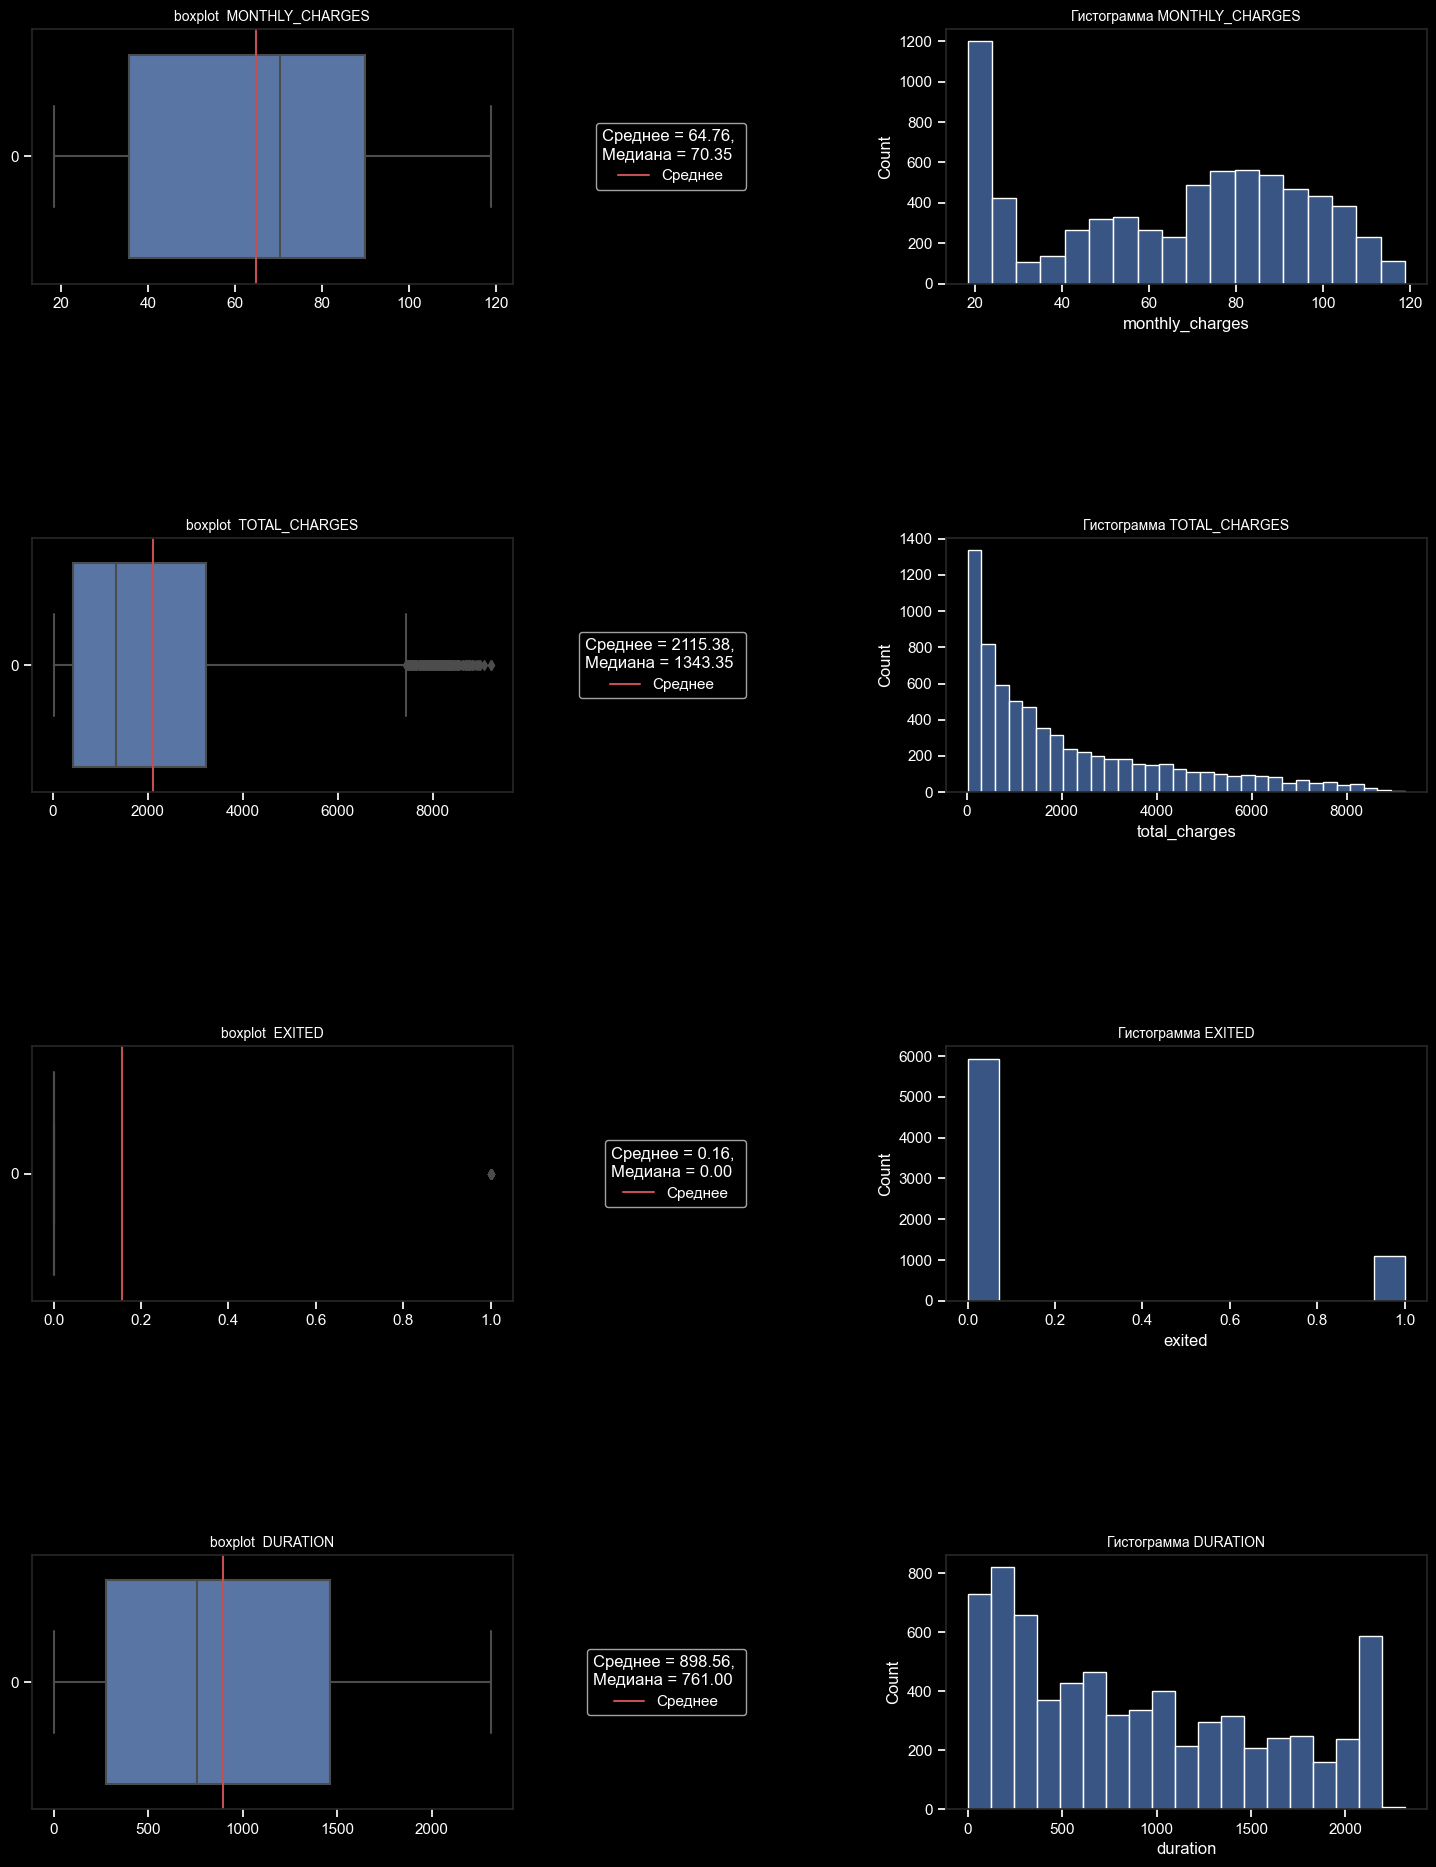

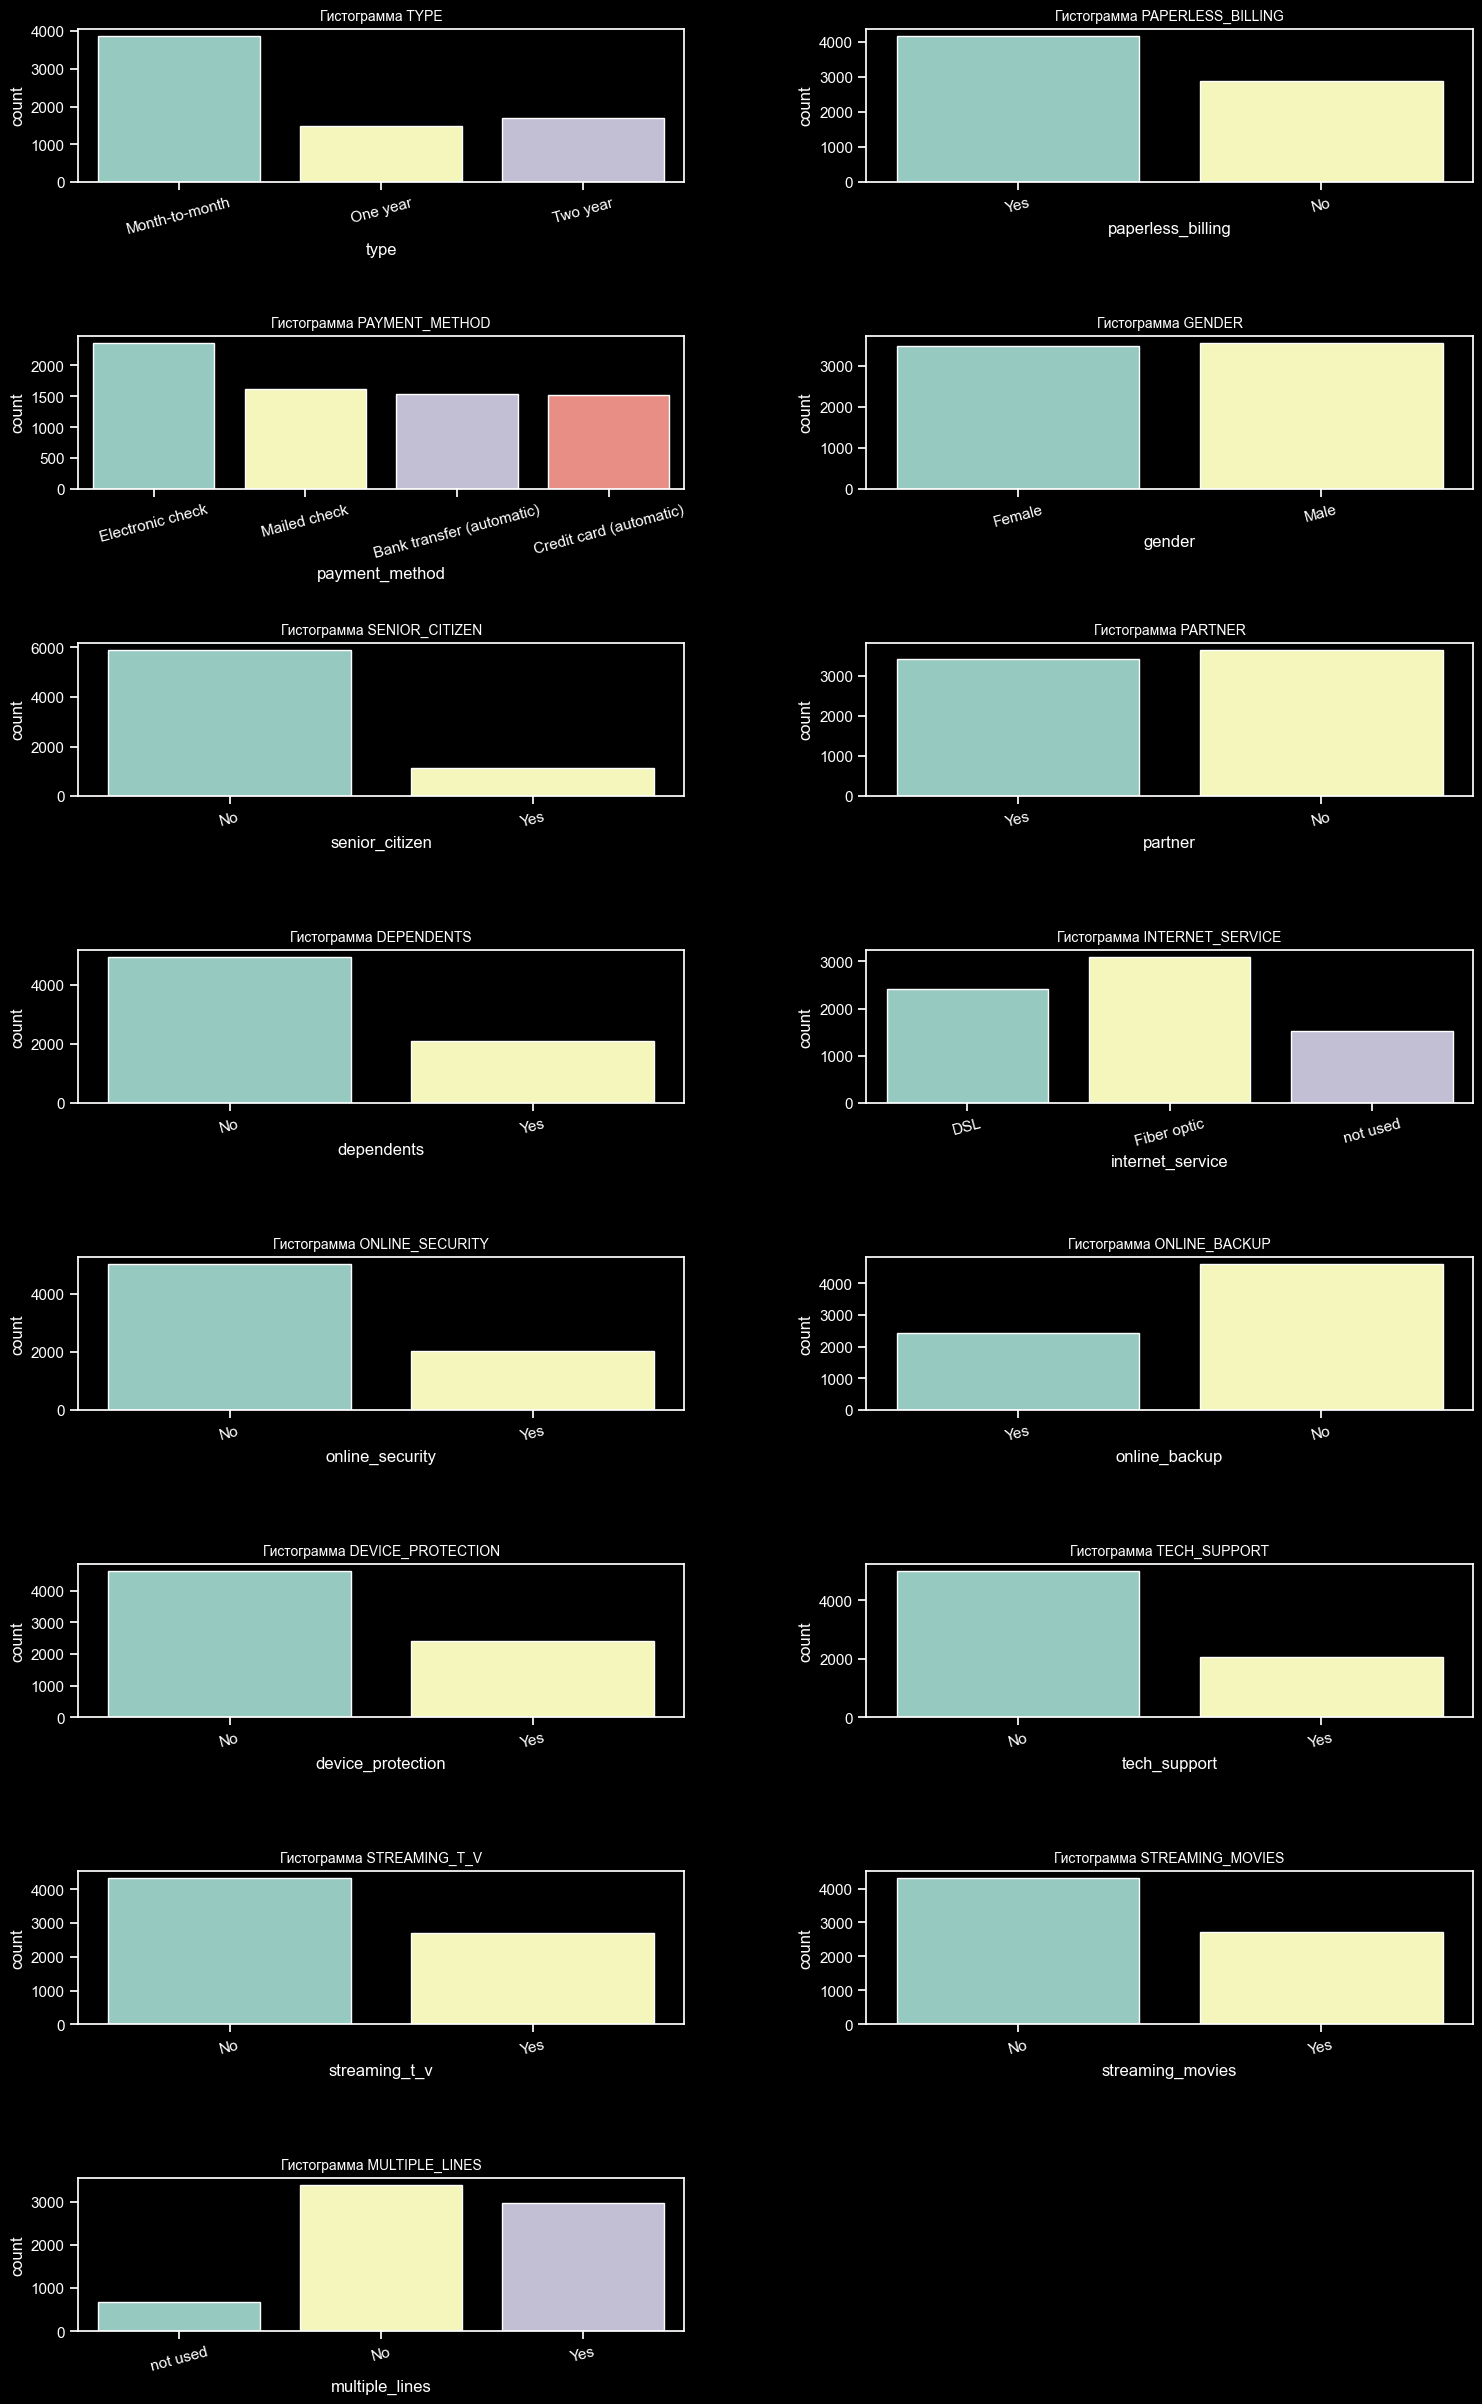

In [34]:
data_info(df)

Типы данных изменены корректно, пропусков в данных больше нет, добавлен таргет и новый признак длинны договора.  

____
Посмотрим на портрет клиента компании.

Преобладающего гендора у среднестатистического клиента нет, клиент не пенсионер, не имеет иждивенцев, не женат, имеет действующий контракт, оплата производится по безбумажному счету, по электронному чеку, с условием оплаты каждый месяц, в среднем оплата в месяц составляет 65 ед., общие поступления по договору клиента 2100, срок договора 900 дней, клиент использует одну телефонную линию, использует оптиковолоконный кабель, не пользуется услунами: блокировка небезопасных сайтов, облачное хранилище, антивирус, выделенная линия технической поддержки, стриминговое телевидение, каталог фильмов.


___
составим портрет клиента, который завершил договор и действующего

In [35]:
df_exited = df.query('exited == 1').copy().reset_index()
df_exited = df_exited.drop('index', axis=1)
df_exited.head(3)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,exited,duration
0,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,No,No,Yes,DSL,Yes,Yes,No,No,No,No,No,1,882
1,2014-05-01,2016-03-01,Two year,No,Credit card (automatic),113.25,2491.50,Female,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1,670
2,2017-08-01,2018-09-01,Month-to-month,Yes,Bank transfer (automatic),55.30,726.09,Female,No,No,No,DSL,Yes,Yes,No,No,No,No,No,1,396


In [36]:
df_active = df.query('exited == 0').copy().reset_index()
df_active = df_active.drop('index', axis=1)
df_active.head(3)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,exited,duration
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,not used,0,31
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123


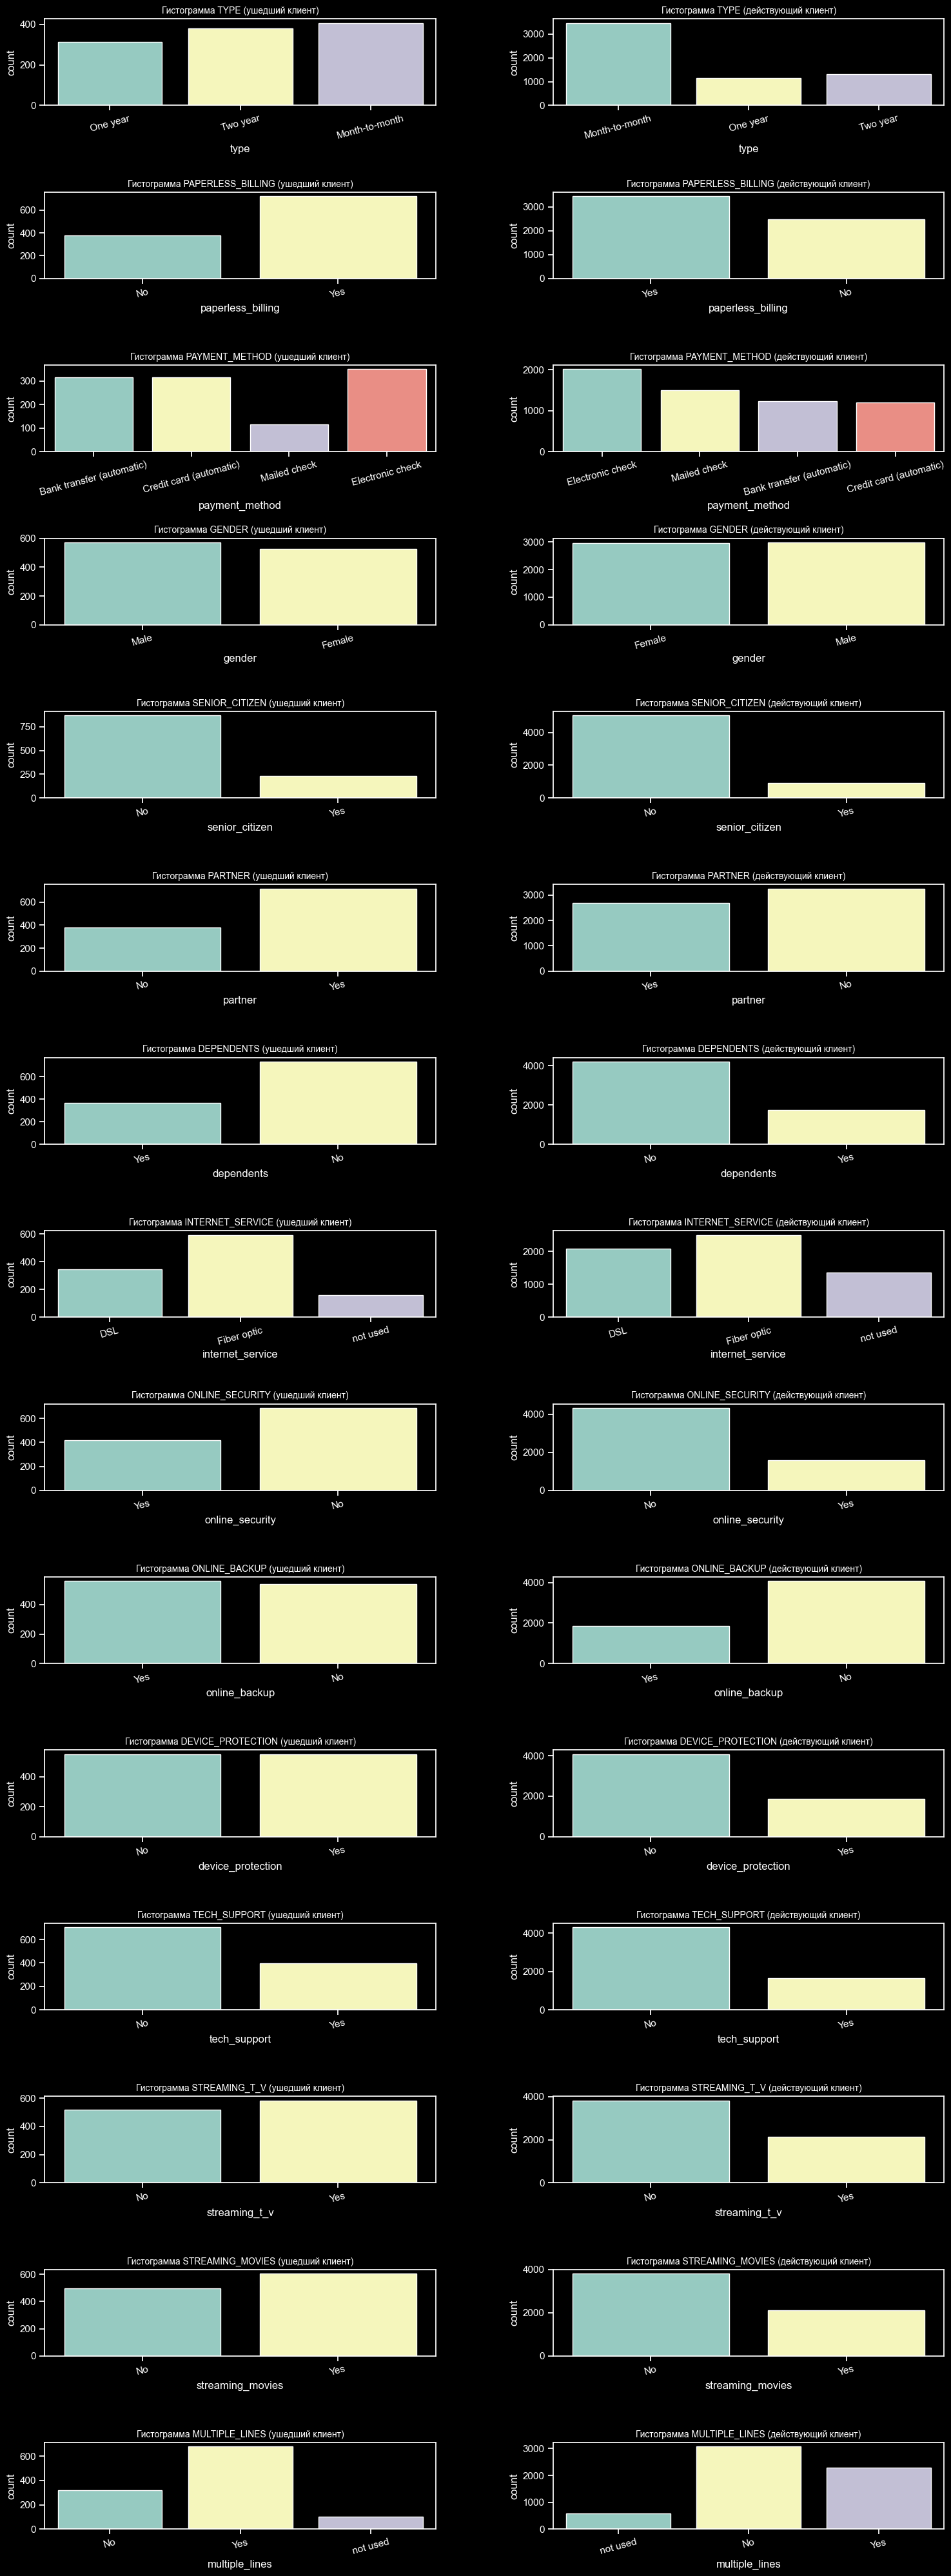

In [37]:
# Гистограмма сравнения для нечисловых столбцов
plt.style.use('dark_background')
position = 0
plt.figure(figsize=[18, 28])
plt.subplots_adjust(top=1.5, wspace=0.3, hspace=1)

for column_name in df_exited.select_dtypes(include=[object]).columns:
    position += 1
    plt.subplot(len(df_exited.select_dtypes(include=[object]).columns), 2, position)
    plt.title(f'Гистограмма {column_name.upper()} (ушедший клиент)', fontsize=10)
    plt.ylabel('Количество')
    plt.xticks(rotation=15)
    sns.countplot(x=column_name, data=df_exited)

    position += 1
    plt.subplot(len(df_active.select_dtypes(include=[object]).columns), 2, position)
    plt.title(f'Гистограмма {column_name.upper()} (действующий клиент)', fontsize=10)
    plt.ylabel('Количество')
    plt.xticks(rotation=15)
    sns.countplot(x=column_name, data=df_active)
plt.show()

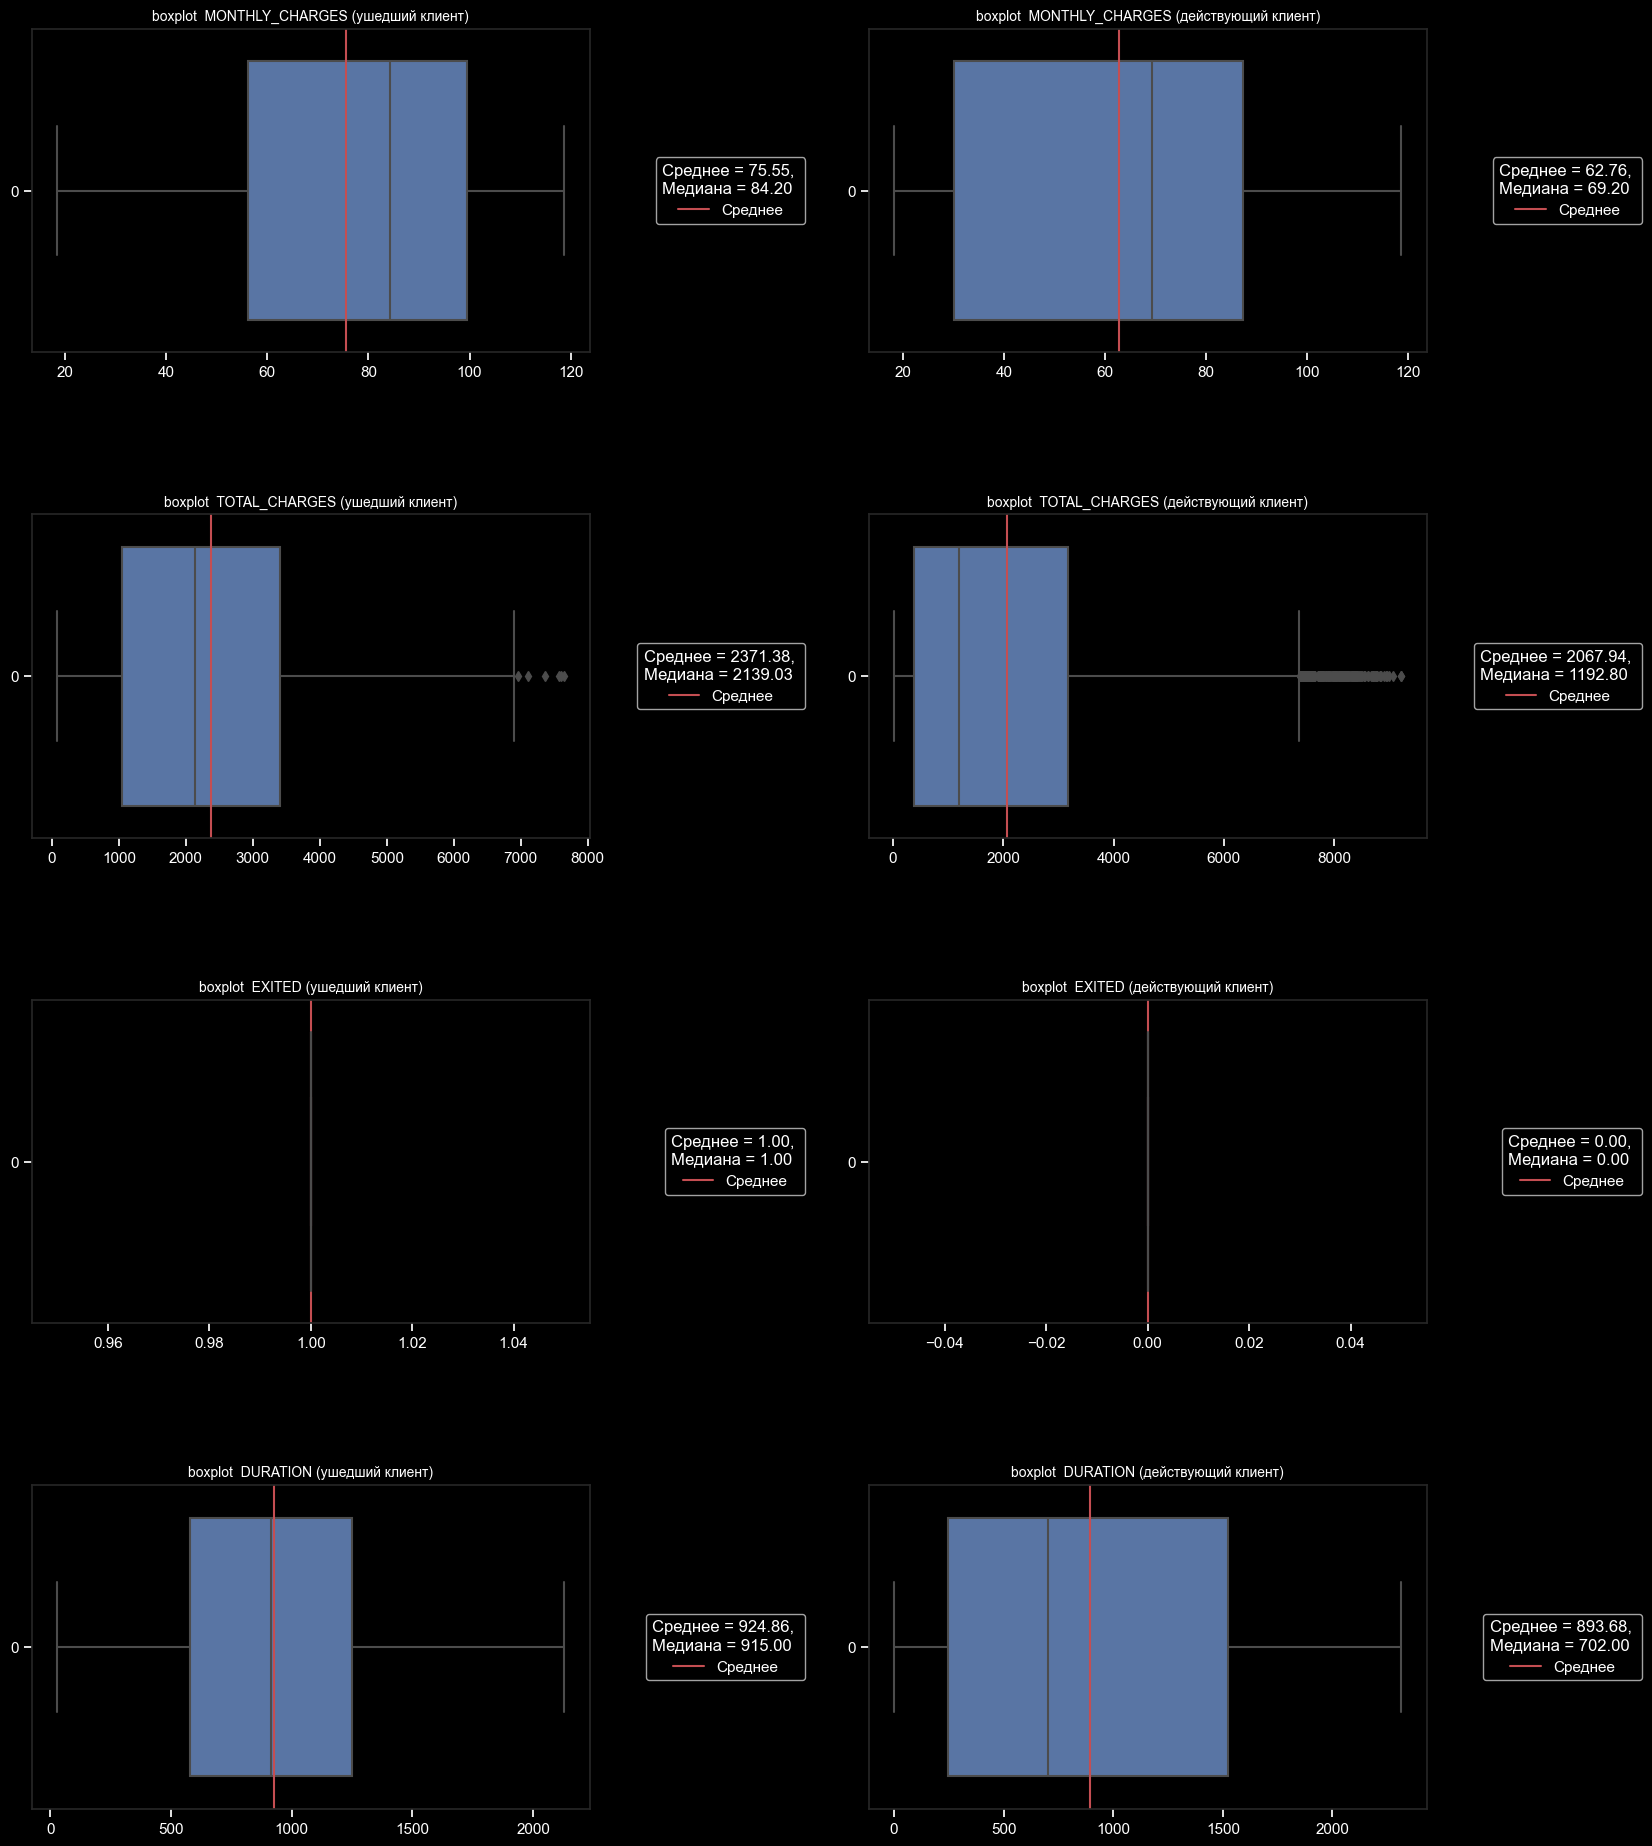

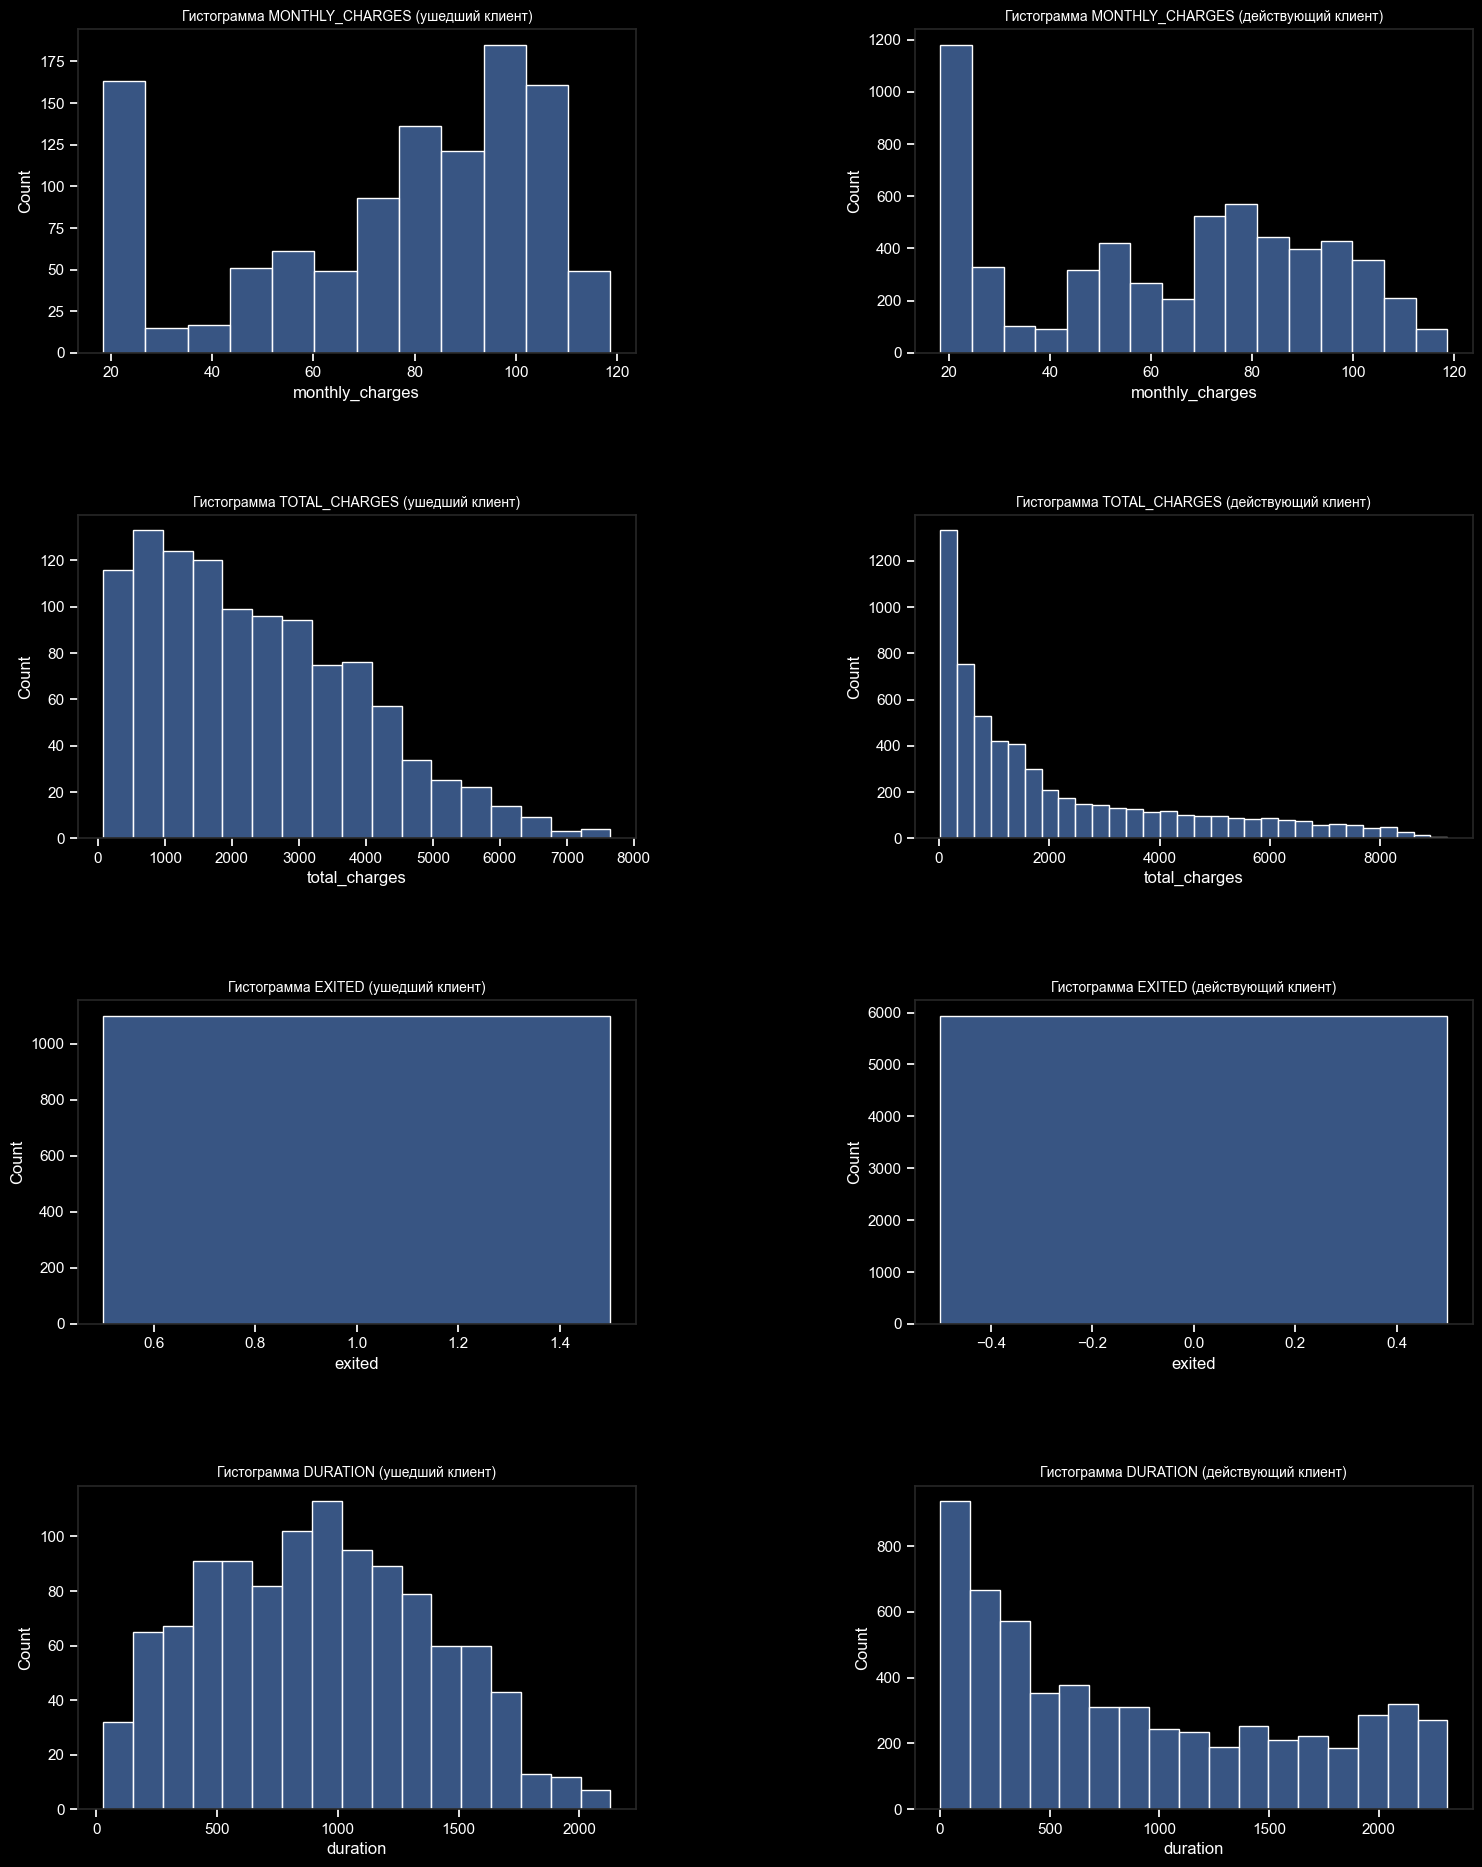

In [38]:
# боксплот и гистограмма сравнения портрета клиента по числовым столбцам
def plot_boxplot(df, column_name, label):
    plt.subplot(len(df.select_dtypes(include=np.number).columns), 2, position)
    plt.title(f'boxplot  {column_name.upper()} ({label} клиент)', fontsize=10)
    sns.boxplot(data=df[column_name], orient='h')
    plt.axvline(np.mean(df[column_name]), color='r', linestyle='-', label='Среднее')
    plt.legend(title=f'Среднее = {np.mean(df[column_name]):.2f}, \nМедиана = {np.median(df[column_name]):.2f}', 
               loc='right', bbox_to_anchor=(1.4, 0.5))

def plot_histogram(df, column_name, label):
    plt.subplot(len(df.select_dtypes(include=np.number).columns), 2, position)
    plt.title(f'Гистограмма {column_name.upper()} ({label} клиент)', fontsize=10)
    sns.histplot(df[column_name])

plt.style.use('dark_background')
position = 0
plt.figure(figsize=[18, 20])
plt.subplots_adjust(top=1, wspace=0.5, hspace=0.5)
custom_params = {'text.color': 'white', 'xtick.color': 'white',
                 'ytick.color': 'white', 'axes.labelcolor': 'white','axes.facecolor': 'black'}
sns.set_theme(style="ticks", rc=custom_params)

for column_name in df_exited.select_dtypes(include=np.number).columns:
    position += 1
    plot_boxplot(df_exited, column_name, 'ушедший')
    position += 1
    plot_boxplot(df_active, column_name, 'действующий')

plt.show()

plt.style.use('dark_background')
position = 0
plt.figure(figsize=[18, 20])
plt.subplots_adjust(top=1, wspace=0.5, hspace=0.5)
custom_params = {'text.color': 'white', 'xtick.color': 'white',
                 'ytick.color': 'white', 'axes.labelcolor': 'white','axes.facecolor': 'black'}
sns.set_theme(style="ticks", rc=custom_params)

for column_name in df_exited.select_dtypes(include=np.number).columns:
    position += 1
    plot_histogram(df_exited, column_name, 'ушедший')
    position += 1
    plot_histogram(df_active, column_name, 'действующий')

plt.show()


Ушедший клиент **мужчина**, клиент не пенсионер, не имеет иждивенцев, **женат**, оплата производится по безбумажному счету, по электронному чеку, с условием оплаты каждый месяц, в **среднем оплата в месяц составляет 76** ед., **общие поступления по договору клиента 2300**, **срок договора 925 дней**, **клиент использует несколько телефонных линий**, использует оптиковолоконный кабель, не пользуется услугами: блокировка небезопасных сайтов, выделенная линия технической поддержки, **использует  стриминговое телевидение, каталог фильмов, облачное хранилище**, может использовать антивирус(половина ушедших клиентов использует)

Преобладающего гендора у среднестатистического действующего клиента нет, клиент не пенсионер, не имеет иждивенцев, не женат, оплата производится по безбумажному счету, по электронному чеку, с условием оплаты каждый месяц, в среднем оплата в месяц составляет 63 ед., общие поступления по договору клиента 2000, срок договора 893 дня, клиент использует 1 телефонную линию, использует оптиковолоконный кабель, не пользуется услунами: блокировка небезопасных сайтов, облачное хранилище, антивирус, выделенная линия технической поддержки, стриминговое телевидение, каталог фильмов.

___
посмотрим на динамику притока/оттока клиентов

In [39]:
start = pd.DataFrame(df.groupby('begin_date')['type'].count())
start.tail(3)

,type
begin_date,
2019-12-01,220
2020-01-01,233
2020-02-01,11


In [40]:
end = pd.DataFrame(df.groupby('end_date')['type'].count())
end.drop(pd.to_datetime('2020-02-01'), inplace=True)
agreements = pd.merge(start, end, left_index=True, right_index=True, how='outer') 
agreements.columns = ['start', 'end']
agreements['end'] = agreements['end'].fillna(0)
agreements['active_clients'] = agreements['start'].cumsum() - agreements['end'].cumsum()

agreements.tail(3)


,start,end,active_clients
2019-12-01,220,38.0,5737.0
2020-01-01,233,39.0,5931.0
2020-02-01,11,0.0,5942.0


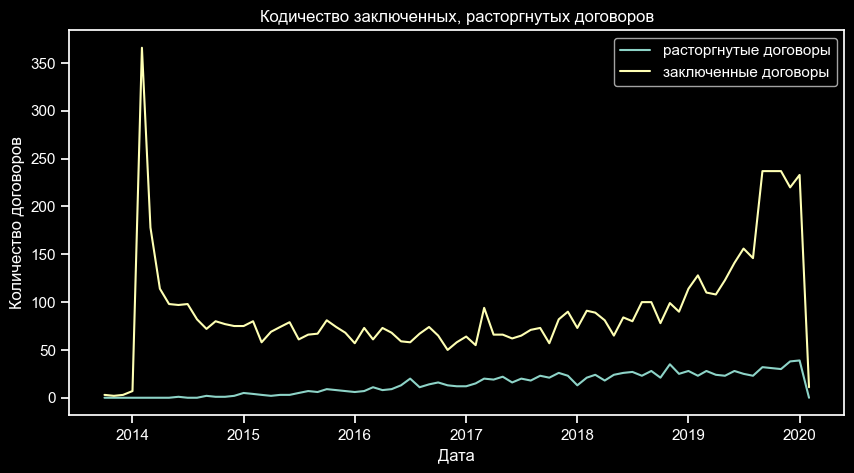

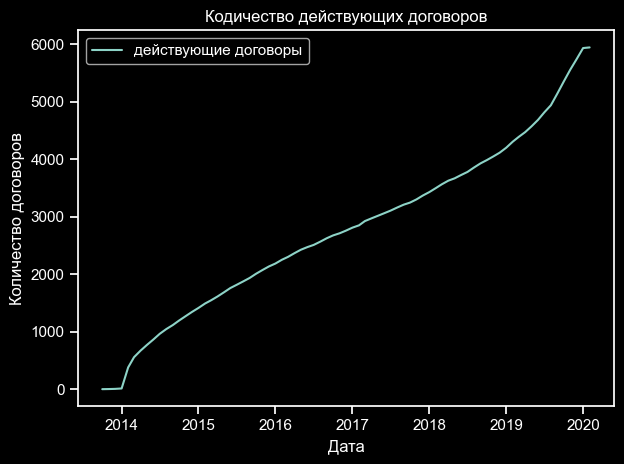

In [41]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.plot(agreements.index, agreements['end'], label='расторгнутые договоры')
plt.plot(agreements.index, agreements['start'], label='заключенные договоры')
plt.xlabel('Дата')
plt.ylabel('Количество договоров')
plt.title('Кодичество заключенных, расторгнутых договоров')
plt.legend()
plt.show()
plt.plot(agreements.index, agreements['active_clients'], label='действующие договоры')
plt.xlabel('Дата')
plt.ylabel('Количество договоров')
plt.title('Кодичество действующих договоров')
plt.legend()
plt.tight_layout()
plt.show()

в январе 2020 заключено только 11 договоров, возможно на последнюю дату данные неполные.  
с 2019 наблюдается прирост действующих договоров, в то время как количество расторжений не так заметно растет. При этом количество действующих клиентов неизменно растет, отток клиентов не имеет сильного негативного действия на действующий портфель договоров.

удалим признаки с датами, т.к. создан признак duration, чтобы не создавать сильную корреляцию признаков.

In [42]:
df = df.drop(columns=['begin_date', 'end_date'])
df.head(5)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,exited,duration
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,not used,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,not used,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


посмотрим на корреляцию признаков 

In [43]:
interval_cols = df.select_dtypes(include=np.number).columns
interval_cols = interval_cols.drop('exited')
interval_cols

Index(['monthly_charges', 'total_charges', 'duration'], dtype='object')

In [44]:
phik_overview = df.phik_matrix(interval_cols=interval_cols)

In [45]:
phik_overview.style.background_gradient('coolwarm')

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,exited,duration
type,1.000000,0.106860,0.277462,0.388444,0.468471,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.244410,0.094015,0.634155
paperless_billing,0.106860,1.000000,0.370495,0.467812,0.203144,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.099953,0.083398,0.026799
payment_method,0.277462,0.370495,1.000000,0.399526,0.335175,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.174849,0.214832,0.350964
monthly_charges,0.388444,0.467812,0.399526,1.000000,0.711029,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.709983,0.226280,0.387727
total_charges,0.468471,0.203144,0.335175,0.711029,1.000000,0.000000,0.137707,0.381042,0.082134,0.489674,0.521522,0.622643,0.641455,0.549866,0.642144,0.644671,0.467339,0.304287,0.847414
gender,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
senior_citizen,0.086231,0.242133,0.292725,0.304985,0.137707,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.087925,0.086159,0.063315
partner,0.179736,0.013218,0.243008,0.203545,0.381042,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.086249,0.226688,0.453688
dependents,0.147680,0.172593,0.224903,0.184366,0.082134,0.000000,0.324576,0.652122,1.000000,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.011198,0.046871,0.198729
internet_service,0.505187,0.231438,0.323886,0.919002,0.489674,0.000000,0.160702,0.000000,0.108463,1.000000,0.241421,0.233602,0.232916,0.239663,0.272818,0.272782,0.739808,0.056621,0.060845


* `type` сильно коррелирует с duration
* `monthly_charges` сильно коррелирует с total_charges, internet_service, streaming_t_v, streaming_movies и multiple_lines
* `total_charges` сильно коррелирует с duration
* `internet_service` сильно коррелирует с multiple_lines
* `streaming_t_v` сильно коррелирует с streaming_movies

Это может создать проблемы мультиколлинеарности при построении  моделей машинного обучения. 

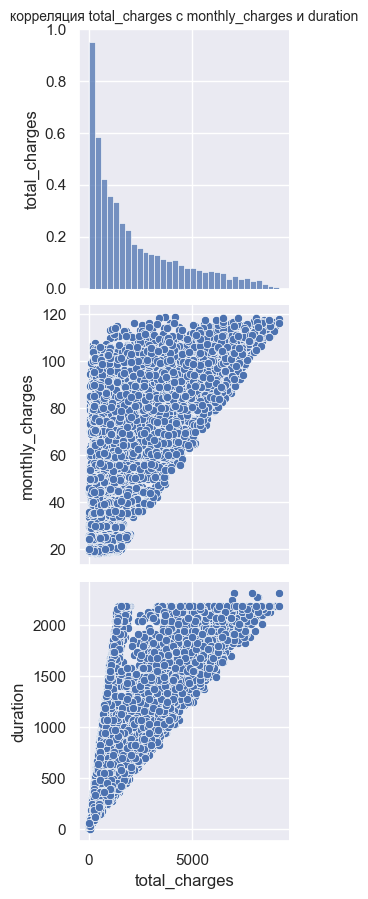

In [46]:
pair = df[['total_charges', 'monthly_charges', 'duration']]
sns.set(font_scale=1)
sns.pairplot(pair, x_vars='total_charges', height=3)
plt.title('корреляция total_charges с monthly_charges и duration', fontsize=10)
plt.show();

чем больше общие поступления от клиента, тем больше его ежемесячный платеж. и чем больше срок договора, тем больше его общие поступления, что логично.

In [47]:
def cross (index, columns):
    table = pd.crosstab(index=index, columns=columns)
    return table
cross(df['internet_service'], df['multiple_lines'])

multiple_lines,No,Yes,not used
internet_service,,,
DSL,1048,691,682
Fiber optic,1158,1938,0
not used,1184,342,0


клиенты, не использующие телефонию имеют DSL кабель, а те у кого 2 тел.линии используют оптиковолоконный кабель. У клиентов, не использующих интернет обычно 1 телефонная линия

In [48]:
cross(df['streaming_t_v'], df['streaming_movies'])

streaming_movies,No,Yes
streaming_t_v,,
No,3544,792
Yes,767,1940


клиенты, использующие cтриминговое телевидение, также часто использкуют каталог фильмов

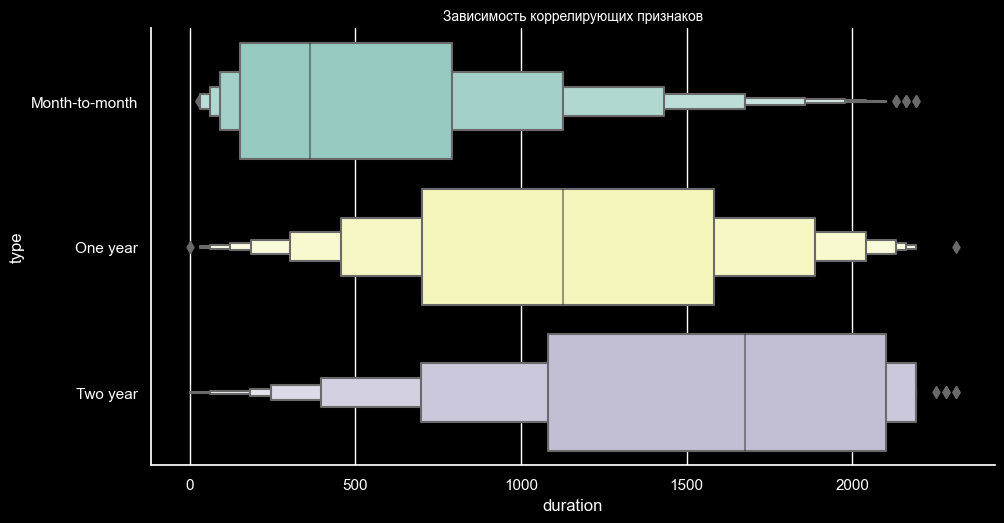

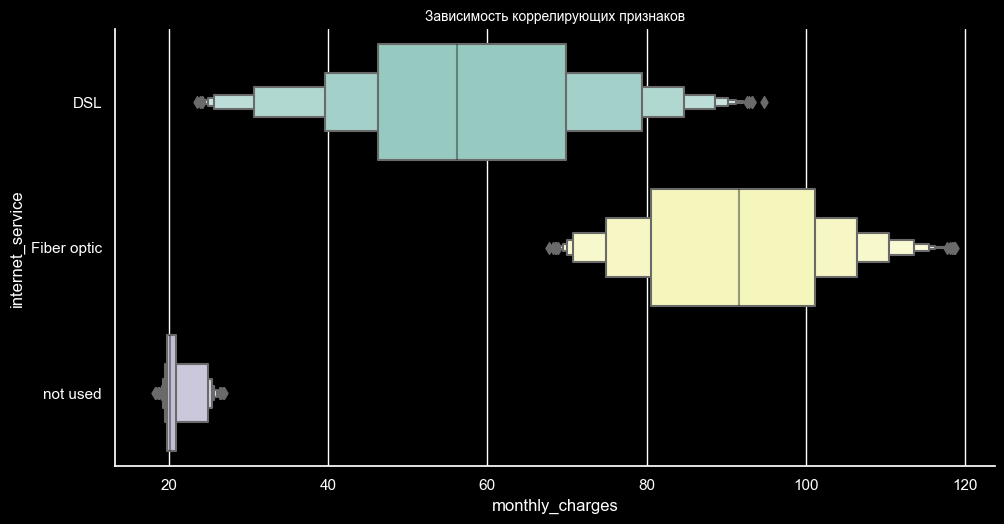

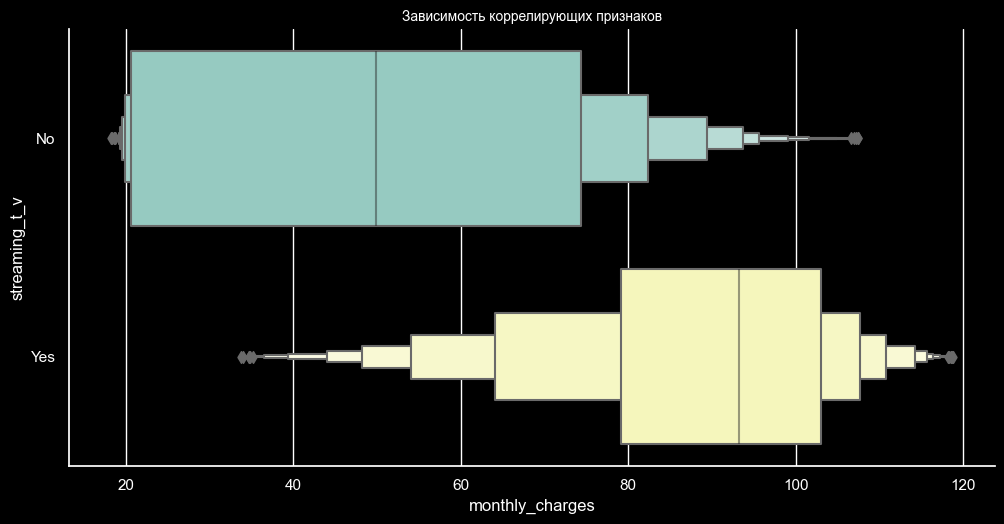

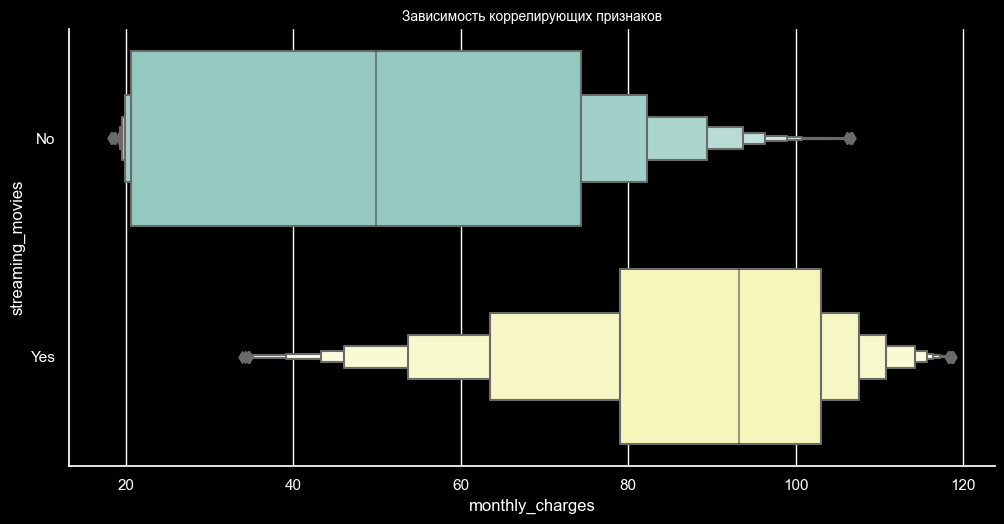

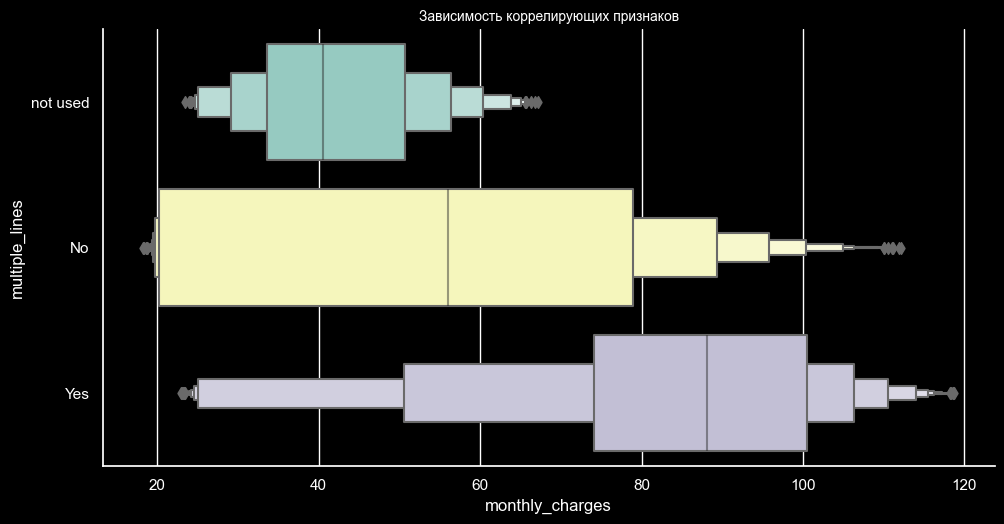

In [49]:
plt.style.use('dark_background')
def catplot(x, y):
    sns.catplot(data=df, x=x, y=y, height=5, aspect=2, kind="boxen")
    plt.title('Зависимость коррелирующих признаков', fontsize=10)
    plt.show();
catplot('duration', 'type')
catplot('monthly_charges', 'internet_service')
catplot('monthly_charges', 'streaming_t_v')
catplot('monthly_charges', 'streaming_movies')
catplot('monthly_charges', 'multiple_lines')


* Чем дольше клиент пользуется услугами, тем более долгий срок у типа договора.  
* Клиенты, использующие оптиковолоконный кабель обычно платят в месяц больше, а те что используют только телефонию платят меньше всего.  
* Если подключена опция стримингового ТВ, каталога фильмов или вторая линия телефонии - ежемесячная оплата возрастает.

In [50]:
phik_overview['exited'].sort_values(ascending=False)

exited               1.000000
duration             0.374569
total_charges        0.304287
online_backup        0.229482
partner              0.226688
monthly_charges      0.226280
streaming_movies     0.222232
device_protection    0.218380
payment_method       0.214832
streaming_t_v        0.200198
online_security      0.132594
multiple_lines       0.105101
tech_support         0.103652
type                 0.094015
senior_citizen       0.086159
paperless_billing    0.083398
internet_service     0.056621
dependents           0.046871
gender               0.008581
Name: exited, dtype: float64

Больше всего коррелирует с целевым признаком duration и total_charges, это было видно также на портрете уходящего клиента

### Выводы

Данные состоят из файлов, полученных из разных источников:

contract_new.csv — информация о договоре;  
personal_new.csv — персональные данные клиента;   
internet_new.csv — информация об интернет-услугах;  
phone_new.csv — информация об услугах телефонии.  

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


* Данные объединены в один датасет по полю customerID
* Датасет содержит 7043 наблюдения
* Присутствали пропуски, они были обработаны без удаления данных
* Преобразованы типы данных 
* Добавлен таргет exited исходя из того, что у ушедших клиентов проставлена дата EndDate
* Добавлен признак duration в днях, вычисляемый из EndDate минус BeginDate
* Дубликатов датасет не содержит

**Портреты клиентов**
- **Портрет среднестатистического клиента компании**  
Преобладающего гендора у среднестатистического клиента нет, клиент не пенсионер, не имеет иждивенцев, не женат, имеет действующий контракт, оплата производится по безбумажному счету, по электронному чеку, с условием оплаты каждый месяц, в среднем оплата в месяц составляет 65 ед., общие поступления по договору клиента 2100, срок договора 900 дней, клиент использует одну телефонную линию, использует оптиковолоконный кабель, не пользуется услунами: блокировка небезопасных сайтов, облачное хранилище, антивирус, выделенная линия технической поддержки, стриминговое телевидение, каталог фильмов. 

- **Портрет среднестатистического ушедшего клиента компании**  
Ушедший клиент **мужчина**, клиент не пенсионер, не имеет иждивенцев, **женат**, оплата производится по безбумажному счету, по электронному чеку, с условием оплаты каждый месяц, в **среднем оплата в месяц составляет 76** ед., **общие поступления по договору клиента 2300**, **срок договора 925 дней**, **клиент использует несколько телефонных линий**, использует оптиковолоконный кабель, не пользуется услугами: блокировка небезопасных сайтов, выделенная линия технической поддержки, **использует  стриминговое телевидение, каталог фильмов, облачное хранилище**, может использовать антивирус(половина ушедших клиентов использует)  

- **Портрет среднестатистического действующего клиента компании**  
Преобладающего гендора у среднестатистического действующего клиента нет, клиент не пенсионер, не имеет иждивенцев, не женат, оплата производится по безбумажному счету, по электронному чеку, с условием оплаты каждый месяц, в среднем оплата в месяц составляет 63 ед., общие поступления по договору клиента 2000, срок договора 893 дня, клиент использует 1 телефонную линию, использует оптиковолоконный кабель, не пользуется услунами: блокировка небезопасных сайтов, облачное хранилище, антивирус, выделенная линия технической поддержки, стриминговое телевидение, каталог фильмов. 

Ушедший клиент отличается тем, что это скорее всего женатый мужчина со среднемесячной оплатой 76 и общими поступоениями 2300 (что выше, чем у действующего), сроком договора 925 дней(что выше, чем у действующего), он использует несколько телефонных линий, использует стриминговое телевидение, каталог фильмов, облачное хранилище и может использовать антивирус(половина ушедших клиентов использует). 
То есть использует больше услуг и, соответственно, платит больше.

**Динамика притока/оттока клиентов**
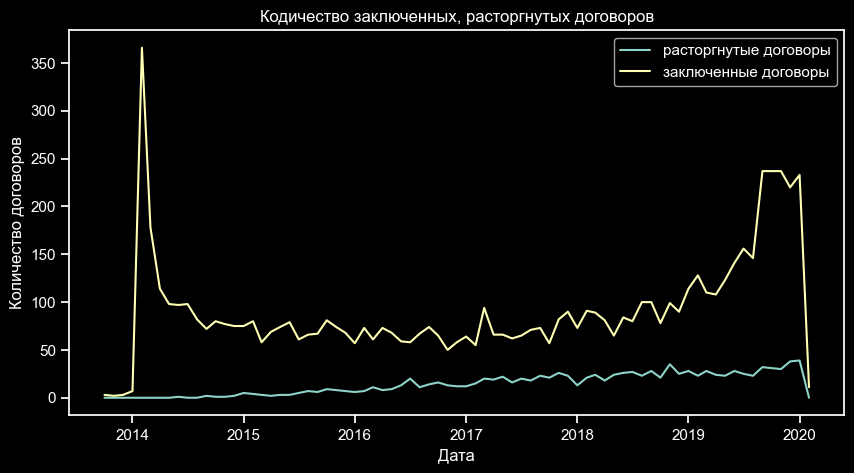
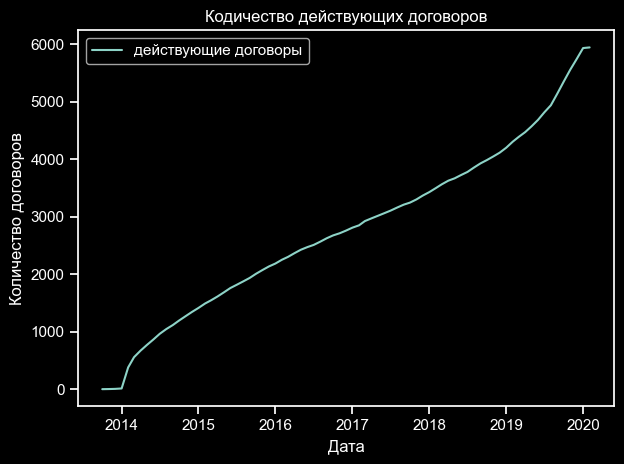
в январе 2020 заключено только 11 договоров, возможно на последнюю дату данные неполные.  
с 2019 наблюдается прирост действующих договоров, в то время как количество расторжений не так заметно растет.   


**Корреляция признаков**
* `type` сильно коррелирует с duration
    * Чем дольше клиент пользуется услугами, тем более долгий срок у типа договора.  
* `monthly_charges` сильно коррелирует с total_charges, internet_service, streaming_t_v, streaming_movies и multiple_lines
    * Чем больше общие поступления от клиента, тем больше его ежемесячный платеж. 
    * Клиенты, использующие оптиковолоконный кабель обычно платят в месяц больше, а те что используют только телефонию платят меньше всего.  
    * Если подключена опция стримингового ТВ, каталога фильмов или вторая линия телефонии - ежемесячная оплата возрастает.
* `total_charges` сильно коррелирует с duration
    * Чем больше срок договора, тем больше его общие поступления.
* `internet_service` сильно коррелирует с multiple_lines
    * клиенты, не использующие телефонию имеют DSL кабель, а те у кого 2 тел.линии используют оптиковолоконный кабель. У клиентов, не использующих интернет обычно 1 телефонная линия
* `streaming_t_v` сильно коррелирует с streaming_movies
    * клиенты, использующие cтриминговое телевидение, также часто использкуют каталог фильмов
        
 

    
Это может создать проблемы мультиколлинеарности при построении  моделей машинного обучения, исправить это можно исключив коррелирующий признак на этапе моделирования. 

Больше всего коррелирует с целевым признаком duration и total_charges

### Список уточняющих вопросов

1. Необходимо ли понимать и предсказывать от какого сегмента услуг клиент хочет отказаться? возможно клиент захочет отказаться только от части услуг, например телефонии и в этом случае спец.условия по тарифу телефонии смогут удержать клиента. 
2. Есть ли данные о наименовании тарифов? возможно ушедшие клиенты пользовались невыгодными/старыми тарифами, это отчасти показывает средняя сумма списания у ушедшего клиента, она выше чем у действующего клиента.

## Моделирование

In [51]:
#разделение на выборки
features = df.drop(['exited'], axis=1)
target = df['exited'] 
for col in features.select_dtypes(include=['object']):
    features[col] = features[col].astype('category')
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=170723)


# проверим размеры воборок
print('features_train' , features_train.shape)
print('target_train', target_train.shape)
print('features_test', features_test.shape)
print('target_test', target_test.shape)


features_train (5282, 18)
target_train (5282,)
features_test (1761, 18)
target_test (1761,)


In [52]:
# числовые и категориальные признаки
numeric = features_train.select_dtypes(exclude='category').columns.to_list()
categorical = features_train.select_dtypes(include=['category']).columns.to_list()
print('численные признаки', numeric)
print('категориальные признаки', categorical)

численные признаки ['monthly_charges', 'total_charges', 'duration']
категориальные признаки ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines']


### LGBM 

In [53]:
#модель
lgbm = LGBMClassifier(objective='binary', random_state=170723)
#параметры
params_lgbm = {
    'n_estimators': optuna.distributions.IntDistribution(4000, 5000),
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_depth': optuna.distributions.IntDistribution(2, 50),
    'reg_alpha': optuna.distributions.FloatDistribution(0.1, 1, step=0.1),
    'reg_lambda': optuna.distributions.FloatDistribution(0.1, 1.0, step=0.1),
    'colsample_bytree': optuna.distributions.FloatDistribution(0.1, 1.0, step=0.1),
    'num_leaves': optuna.distributions.IntDistribution(2, 5)
}

#поиск параметров
search_lgbm = optuna.integration.OptunaSearchCV(lgbm, 
                                                params_lgbm, 
                                                n_trials=50, 
                                                cv = 5, 
                                                scoring="roc_auc", 
                                                timeout=500, 
                                                verbose=0, 
                                                refit=True, 
                                                random_state=170723)
search_lgbm.fit(features_train, target_train)

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-07-25 17:52:44,165] A new study created in memory with name: no-name-0e9edb1a-9b3c-4123-a05f-9e5d07be1cda
[I 2023-07-25 17:52:48,720] Trial 0 finished with value: 0.836663247750318 and parameters: {'n_estimators': 4471, 'learning_rate': 0.06380613891249158, 'max_depth': 32, 'reg_alpha': 0.1, 'reg_lambda': 0.2, 'colsample_bytree': 0.30000000000000004, 'num_leaves': 2}. Best is trial 0 with value: 0.836663247750318.
[I 2023-07-25 17:52:53,586] Trial 1 finished with value: 0.8364398868002112 and parameters: {'n_estimators': 4912, 'learning_rate': 0.05831330245029429, 'max_depth': 20, 'reg_alpha': 0.6, 'reg_lambda': 0.8, 'colsample_bytree': 0.30000000000000004, 'num_leaves': 2}. Best is trial 0 with value: 0.836663247750318.
[I 2023-07-25 17:52:58,115] Trial 2 finished with value: 0.8372032926921648 and parameters: {'n_estimators': 4591, 'learning_rate': 0.05008669064693187, 'max_depth'

OptunaSearchCV(cv=5,
               estimator=LGBMClassifier(objective='binary',
                                        random_state=170723),
               n_jobs=1, n_trials=50,
               param_distributions={'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1),
                                    'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None),
                                    'max_depth': IntDistribution(high=50, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=5000, log=False, low=4000, step=1),
                                    'num_leaves': IntDistribution(high=5, log=False, low=2, step=1),
                                    'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1),
                                    'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1)},
               random_state=170723, scoring='roc_auc', timeout=500)

In [54]:
lgbm = search_lgbm.best_estimator_

#подсчет времени
time = pd.DataFrame.from_dict(search_lgbm.best_trial_.user_attrs, orient='index', columns=['LGBM'])
roc_auc_lgbm = round((search_lgbm.best_score_),4)

print('LightGBM')
print('ROC-AUC:', roc_auc_lgbm)
time

LightGBM
ROC-AUC: 0.9028


,LGBM
mean_fit_time,1.026274
std_fit_time,0.041062
mean_score_time,0.052796
std_score_time,0.007111
split0_test_score,0.918585
split1_test_score,0.884122
split2_test_score,0.893115
split3_test_score,0.906863
split4_test_score,0.911280
mean_test_score,0.902793


### CatBoost

In [55]:
#модель
cat = CatBoostClassifier(cat_features=categorical, eval_metric='AUC', random_state=170723, 
                         verbose=False)

#параметры
params_cat = {
    'n_estimators': optuna.distributions.IntDistribution(2500, 3000),
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.2),
    'depth': optuna.distributions.IntDistribution(5, 16),
    'subsample': optuna.distributions.FloatDistribution(0.05, 1.0),
    'colsample_bylevel': optuna.distributions.FloatDistribution(0.05, 1.0),
    'l2_leaf_reg': optuna.distributions.IntDistribution(1, 16)
}

#поиск параметров
search_cat = optuna.integration.OptunaSearchCV(cat, 
                                               params_cat, 
                                               n_trials=50, 
                                               cv = 5,
                                               scoring="roc_auc", 
                                               timeout=500, 
                                               verbose=0, 
                                               refit=True, 
                                                random_state=170723)
search_cat.fit(features_train, target_train)

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-07-25 17:57:28,426] A new study created in memory with name: no-name-52b52b1a-c062-4874-aa7a-37342031743d
[I 2023-07-25 18:21:10,508] Trial 0 finished with value: 0.7867327068694564 and parameters: {'n_estimators': 2736, 'learning_rate': 0.1272466832685437, 'depth': 12, 'subsample': 0.10038841639083956, 'colsample_bylevel': 0.19931595296741988, 'l2_leaf_reg': 4}. Best is trial 0 with value: 0.7867327068694564.


OptunaSearchCV(cv=5,
               estimator=<catboost.core.CatBoostClassifier object at 0x00000214293401C0>,
               n_jobs=1, n_trials=50,
               param_distributions={'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.05, step=None),
                                    'depth': IntDistribution(high=16, log=False, low=5, step=1),
                                    'l2_leaf_reg': IntDistribution(high=16, log=False, low=1, step=1),
                                    'learning_rate': FloatDistribution(high=0.2, log=False, low=0.001, step=None),
                                    'n_estimators': IntDistribution(high=3000, log=False, low=2500, step=1),
                                    'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None)},
               random_state=170723, scoring='roc_auc', timeout=500)

In [56]:
cat = search_cat.best_estimator_

#подсчет времени
time_cat = pd.DataFrame.from_dict(search_cat.best_trial_.user_attrs, orient='index', 
                              columns=['CatBoost'])
roc_auc_cat = round((search_cat.best_score_),4)

print('CatBoost')
print('ROC-AUC:', roc_auc_cat)
time_cat


CatBoost
ROC-AUC: 0.7867


,CatBoost
mean_fit_time,284.316505
std_fit_time,7.711004
mean_score_time,0.016417
std_score_time,0.000465
split0_test_score,0.793024
split1_test_score,0.788446
split2_test_score,0.764583
split3_test_score,0.798851
split4_test_score,0.788759
mean_test_score,0.786733


### Random Forest

In [57]:
#преобразование для категориальных признаков (OneHotEncoder)
ohe = OneHotEncoder(handle_unknown='ignore', drop='first')

#ColumnTransformer с определенным преобразованием
preprocessor = ColumnTransformer(
    transformers=[('cat', ohe, categorical)],
    remainder='passthrough')

pipeline = Pipeline([('preprocessor', preprocessor), 
                     ('model', RandomForestClassifier(random_state=170723, 
                                                      class_weight='balanced'))])

#параметры
params_forest = {
    'model__n_estimators': optuna.distributions.IntDistribution(100, 5000),
    'model__max_depth': optuna.distributions.IntDistribution(2, 150)
}

#поиск параметров
search_forest = optuna.integration.OptunaSearchCV(pipeline, 
                                                  params_forest, 
                                                  n_trials=50, 
                                                  cv = 5,
                                                  scoring="roc_auc", 
                                                  timeout=500, 
                                                  verbose=0, 
                                                  refit=True, 
                                                random_state=170723)
search_forest.fit(features_train, target_train)

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-07-25 18:25:49,790] A new study created in memory with name: no-name-3fa09800-ce8e-45c8-b751-d6de9fc62204
[I 2023-07-25 18:26:50,909] Trial 0 finished with value: 0.8084225177135191 and parameters: {'model__n_estimators': 2410, 'model__max_depth': 96}. Best is trial 0 with value: 0.8084225177135191.
[I 2023-07-25 18:27:50,822] Trial 1 finished with value: 0.817053903652569 and parameters: {'model__n_estimators': 3177, 'model__max_depth': 9}. Best is trial 1 with value: 0.817053903652569.
[I 2023-07-25 18:28:12,432] Trial 2 finished with value: 0.8083746733845955 and parameters: {'model__n_estimators': 870, 'model__max_depth': 34}. Best is trial 1 with value: 0.817053903652569.
[I 2023-07-25 18:28:21,845] Trial 3 finished with value: 0.8084499726768708 and parameters: {'model__n_estimators': 379, 'model__max_depth': 137}. Best is trial 1 with value: 0.817053903652569.
[I 2023-07-25 1

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('cat',
                                                                           OneHotEncoder(drop='first',
                                                                                         handle_unknown='ignore'),
                                                                           ['type',
                                                                            'paperless_billing',
                                                                            'payment_method',
                                                                            'gender',
                                                                            'senior_citizen',
                                                                            'partner',
                                                                            'dependents',
                                                                            'internet_service',
                                                                            'online_security',
                                                                            'online_backup',
                                                                            'device_protection',
                                                                            'tech_...
                                                                            'streaming_movies',
                                                                            'multiple_lines'])])),
                                         ('model',
                                          RandomForestClassifier(class_weight='balanced',
                                                                 random_state=170723))]),
               n_jobs=1, n_trials=50,
               param_distributions={'model__max_depth': IntDistribution(high=150, log=False, low=2, step=1),
                                    'model__n_estimators': IntDistribution(high=5000, log=False, low=100, step=1)},
               random_state=170723, scoring='roc_auc', timeout=500)

In [58]:
#подсчет времени
forest = search_forest.best_estimator_

time_forest = pd.DataFrame.from_dict(search_forest.best_trial_.user_attrs, orient='index', 
                              columns=['Random Forest'])
roc_auc_forest = round((search_forest.best_score_),4)

print('Random Forest')
print('ROC-AUC:', roc_auc_forest)
time_forest



Random Forest
ROC-AUC: 0.8171


,Random Forest
mean_fit_time,11.388203
std_fit_time,0.093862
mean_score_time,0.579459
std_score_time,0.047559
split0_test_score,0.844890
split1_test_score,0.825888
split2_test_score,0.796282
split3_test_score,0.817572
split4_test_score,0.800638
mean_test_score,0.817054


In [59]:
time['CatBoost'] = time_cat['CatBoost']
time['Random Forest'] = time_forest['Random Forest']
time = time.head(4)

In [60]:
total = time.T

In [61]:
total['ROC-AUC'] = [roc_auc_lgbm, roc_auc_cat, roc_auc_forest]

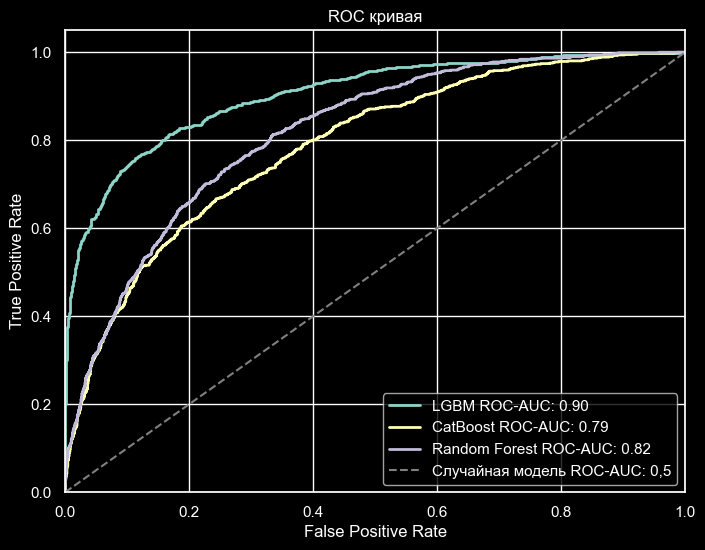

In [62]:
#ROC кривая
models = [lgbm, cat, forest]
cv_probs = [cross_val_predict(model, 
                              features_train, 
                              target_train, 
                              cv=5, 
                              method='predict_proba') for model in models]

plt.figure(figsize=(8, 6))
for model_name, cv_prob in zip(['LGBM', 'CatBoost', 'Random Forest'], cv_probs):
    fpr, tpr, thresholds = roc_curve(target_train, cv_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} ROC-AUC: {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Случайная модель ROC-AUC: 0,5')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()


### Выводы

Все модели показали результат лучше случайной модели.  
Лучшую метрику ROC-AUC показала модель LightGBM, она также самая быстрая во время обучения. 
ROC-AUC выше требуемого порога 0.85, модель будет проверена на тестовой выборке 
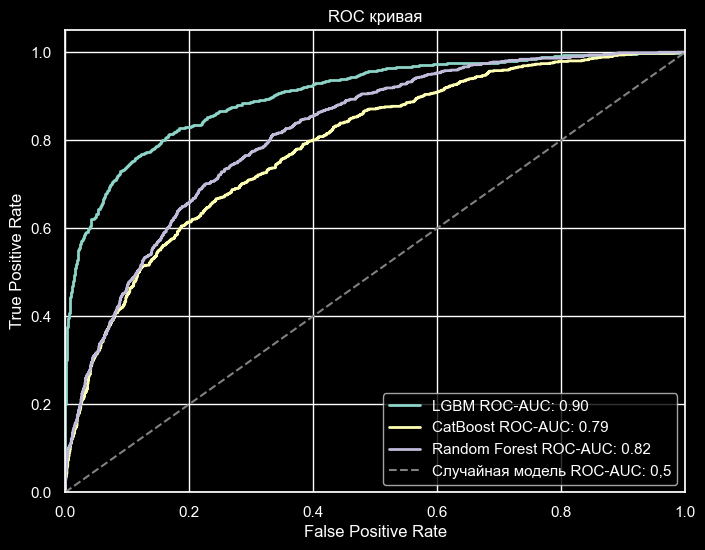

In [63]:
total

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,ROC-AUC
LGBM,1.026274,0.041062,0.052796,0.007111,0.9028
CatBoost,284.316505,7.711004,0.016417,0.000465,0.7867
Random Forest,11.388203,0.093862,0.579459,0.047559,0.8171


## Тестирование

In [64]:
pred_prob = lgbm.predict_proba(features_test)[:,1]

In [65]:
fpr, tpr, thresholds = roc_curve(target_test, pred_prob)

ROC-AUC тестовая выборка: 0.9305
Accuracy тестовая выборка: 0.929


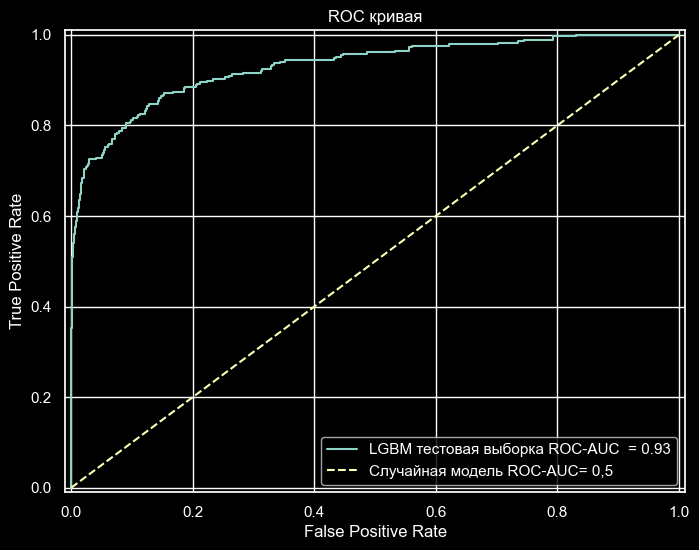

In [66]:
#площадь под ROC-кривой
roc_auc_test = round(roc_auc_score(target_test, pred_prob),4)
print('ROC-AUC тестовая выборка:', roc_auc_test)

#accuracy
pred = lgbm.predict(features_test)
accuracy = round(accuracy_score(target_test, pred),4)
print("Accuracy тестовая выборка:", accuracy)
#ROC-кривая
plt.figure(figsize=(8, 6))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

plt.plot(fpr, tpr, label='LGBM тестовая выборка ROC-AUC  = {:.2f}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', label='Случайная модель ROC-AUC= 0,5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc='lower right')
plt.show()


### Выводы

Тестирование показало, что модель пригодна для использования, метрика ROC-AUC превосходит требуемый порог в 0.85, также модель прошла проверку на вменяемость

In [67]:
print('ROC-AUC тестовая выборка:', roc_auc_test)
print("Accuracy тестовая выборка:", accuracy)

ROC-AUC тестовая выборка: 0.9305
Accuracy тестовая выборка: 0.929


## Исследование модели

### Матрица ошибок

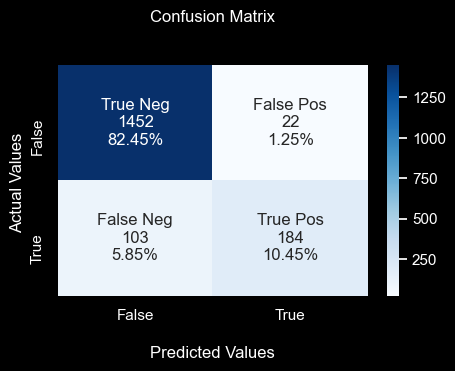

In [68]:
def c_matrix(target, pred):
    cm = confusion_matrix(target, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5, 3))
    ax = sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()
c_matrix(target_test, pred)

модель склонна больше к ошибке 2 рода (пропускать событие). Такая ошибка приводит к потерям ежемесячной оплаты от клиента.

### Калибровка и подбор порога

Попробуем минимизировать убытки подобрав отпимальный порог

In [160]:
#средняя ежемесячная плата
charges_exited = df.query('exited ==1')['monthly_charges'].mean()
charges_active = df.query('exited ==0')['monthly_charges'].mean()
#предполагаемые дисконт и кол-во клиентов, решивших остаться после спец.предложения
discount = 0.1
conversion_rate = 0.7

#расчет предполагаемых потерь
losses = {}
for threshold in np.linspace(0, 1, 100):
    fp_count = ((pred_prob > threshold) & (target_test == 0)).sum()
    fn_count = ((pred_prob <= threshold) & (target_test == 1)).sum()
    
    #расчет потерь от ошибки 1 и 2 рода
    fp_loss = fp_count * (charges_active * discount)
    fn_loss = fn_count * charges_exited
    
    #расчет убытка по порогу
    total_loss = fp_loss + (1 - conversion_rate) * fn_loss
    losses[threshold] = total_loss

#оптимальный порог и минимальный убыток
optimal_threshold = min(losses, key=losses.get)
min_losses = losses[optimal_threshold]

print("оптимальный порог:", optimal_threshold)
print("минимальный убыток:", min_losses)


оптимальный порог: 0.37373737373737376
минимальный убыток: 2085.4285249120244


In [161]:
calibrated_pred = (pred_prob > optimal_threshold).astype(int)

In [162]:
accuracy_calibrated = accuracy_score(target_test, calibrated_pred)
print("Accuracy тестовая выборка:", accuracy)
print("Accuracy тестовая выборка с оптимальным порогом:", accuracy_calibrated)

Accuracy тестовая выборка: 0.929
Accuracy тестовая выборка с оптимальным порогом: 0.9284497444633731


Общее число правильных ответов с подобранным порогом снизилось, но должно быть меньше ошибки 2 рода. посмотрим на матрице ошибок

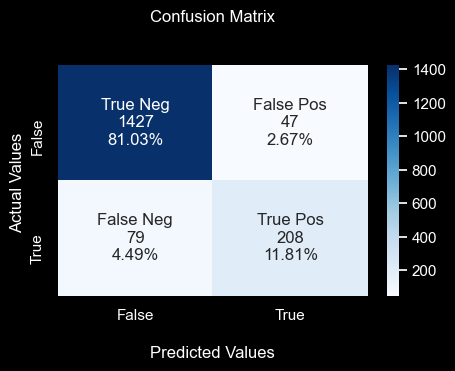

In [163]:
c_matrix(target_test, calibrated_pred)

Подбор порога к увеличению истинно положительных ответов, уменьшению ошибки 2 рода(пропуск ушедшего клиента), но привела к увеличению ошибки 1 рода (ошибочное указание на то, что клиент собирается уйти) и к снижению количества истинно отрицательных значений. Необходимо уточнение данных по дисконту и конверсии для более детальной калибровки

калибровка

In [164]:
lgbm = search_lgbm.best_estimator_

In [165]:
np.random.seed(170723)
calibrated_sig = CalibratedClassifierCV(lgbm, method='sigmoid', cv="prefit").fit(features_train, target_train)
calibrated_iso = CalibratedClassifierCV(lgbm, method='isotonic', cv="prefit").fit(features_train, target_train)

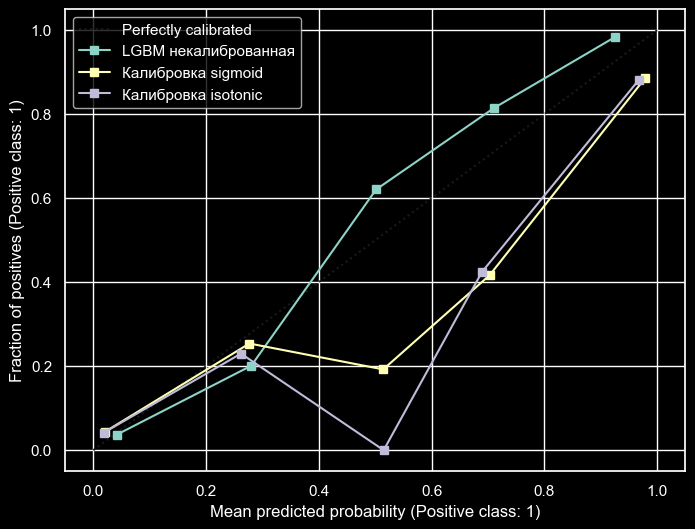

In [166]:

fig, ax = plt.subplots(figsize=(8, 6))
lgbm = CalibrationDisplay.from_estimator(lgbm, features_test, target_test, ax=ax, label='LGBM некалиброванная')
calibration_sig = CalibrationDisplay.from_estimator(calibrated_sig, 
                                                    features_test, 
                                                    target_test, 
                                                    ax=ax, label='Калибровка sigmoid')
calibration_iso = CalibrationDisplay.from_estimator(calibrated_iso, 
                                                    features_test, 
                                                    target_test, 
                                                    ax=ax, label='Калибровка isotonic')

ax.legend()
plt.show()


калибровка в данном случае не требуется, модель LGBM сработала точнее

### Важность признаков

In [168]:
lgbm = search_lgbm.best_estimator_
feature_importances = lgbm.feature_importances_

feature_importance_df = pd.DataFrame({'feature': features_test.columns, 'importance': feature_importances})
feature_importance_df.sort_values(by='importance', ascending=False)

,feature,importance
17,duration,5377
3,monthly_charges,2856
4,total_charges,2533
2,payment_method,311
0,type,266
7,partner,243
16,multiple_lines,172
1,paperless_billing,92
9,internet_service,91
6,senior_citizen,84


Больше всего важны duration	monthly_charges и total_charges

In [169]:
shap_test = shap.TreeExplainer(lgbm).shap_values(features_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [170]:
feature_test_disp = features_test.replace({'Yes': 1, 'No': 0})
feature_test_disp = feature_test_disp.replace({'Male': 1, 'Female': 0})

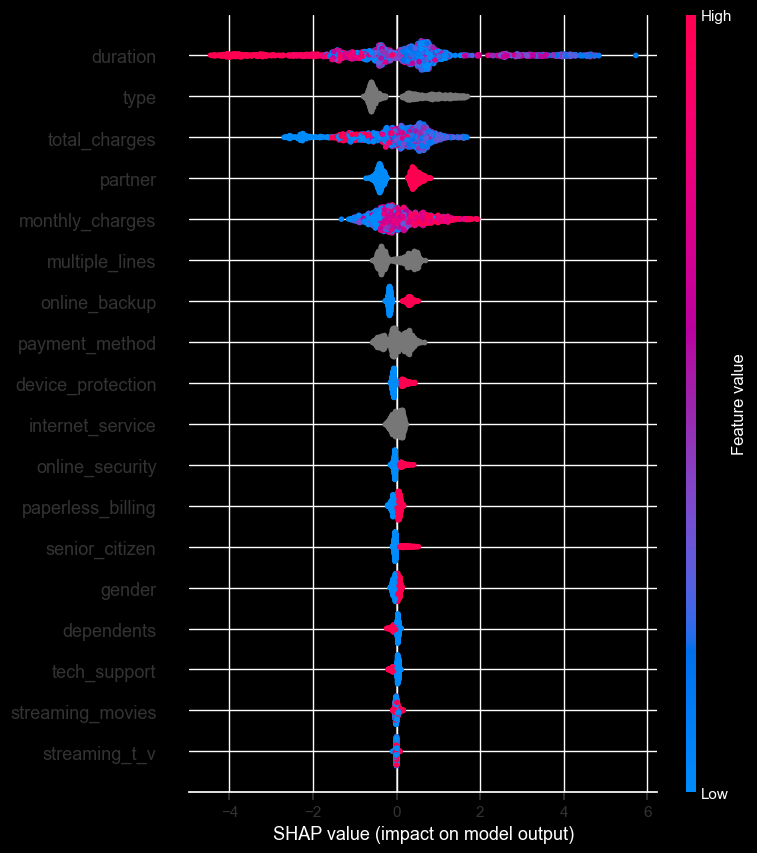

In [171]:
shap.summary_plot(shap_test[1], feature_test_disp)

'streaming_t_v', 'streaming_movies' и 'gender' не привносят вклад в обучение модели, попробуем обойтись без них

Попробуем обучить модель только на самых значимых признаках

In [172]:
#только значимые признаки, 3 последних отбросим
i = features.columns.drop(['streaming_movies', 'streaming_t_v', 
                       'gender'])
i

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'multiple_lines', 'duration'],
      dtype='object')

In [176]:
#модель
model = LGBMClassifier(objective='binary', random_state=170723)
#параметры
params_lgbm = {
    'n_estimators': optuna.distributions.IntDistribution(4000, 5000),
    'learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1),
    'max_depth': optuna.distributions.IntDistribution(2, 50),
    'reg_alpha': optuna.distributions.FloatDistribution(0.1, 1, step=0.1),
    'reg_lambda': optuna.distributions.FloatDistribution(0.1, 1.0, step=0.1),
    'colsample_bytree': optuna.distributions.FloatDistribution(0.1, 1.0, step=0.1),
    'num_leaves': optuna.distributions.IntDistribution(2, 5)
}

#поиск параметров
search_lgbm_i = optuna.integration.OptunaSearchCV(model, 
                                                params_lgbm, 
                                                n_trials=50, 
                                                cv = 5, 
                                                scoring="roc_auc", 
                                                timeout=500, 
                                                verbose=0, 
                                                refit=True)
search_lgbm_i.fit(features_train[i], target_train)

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-07-25 21:28:19,399] A new study created in memory with name: no-name-c59b516c-00ee-4b06-9ccf-395d2e701409
[I 2023-07-25 21:28:25,679] Trial 0 finished with value: 0.9011268147221332 and parameters: {'n_estimators': 4481, 'learning_rate': 0.044917401610550495, 'max_depth': 50, 'reg_alpha': 1.0, 'reg_lambda': 0.8, 'colsample_bytree': 0.6, 'num_leaves': 5}. Best is trial 0 with value: 0.9011268147221332.
[I 2023-07-25 21:28:31,034] Trial 1 finished with value: 0.8935265080137693 and parameters: {'n_estimators': 4686, 'learning_rate': 0.07979169918687712, 'max_depth': 26, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.8, 'colsample_bytree': 1.0, 'num_leaves': 5}. Best is trial 0 with value: 0.9011268147221332.
[I 2023-07-25 21:28:34,051] Trial 2 finished with value: 0.840202225335973 and parameters: {'n_estimators': 4300, 'learning_rate': 0.06319469413032673, 'max_depth': 40, 'reg_alp

OptunaSearchCV(cv=5,
               estimator=LGBMClassifier(objective='binary',
                                        random_state=170723),
               n_jobs=1, n_trials=50,
               param_distributions={'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1),
                                    'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None),
                                    'max_depth': IntDistribution(high=50, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=5000, log=False, low=4000, step=1),
                                    'num_leaves': IntDistribution(high=5, log=False, low=2, step=1),
                                    'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1),
                                    'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1)},
               scoring='roc_auc', timeout=500)

In [175]:
lgbm_i = search_lgbm_i.best_estimator_
pred_prob_imp = lgbm_i.predict_proba(features_test[i])[:, 1]

roc_auc_test_imp = round(roc_auc_score(target_test, pred_prob_imp),4)
print('ROC-AUC тестовая выборка все фичи:', roc_auc_test)
print('ROC-AUC тестовая выборка только важные фичи:', roc_auc_test_imp)

#accuracy
pred_imp = lgbm_i.predict(features_test[i])
accuracy_imp = round(accuracy_score(target_test, pred_imp),4)
print("Accuracy тестовая выборка все фичи:", accuracy)
print("Accuracy тестовая выборка только важные фичи:", accuracy_imp)

ROC-AUC тестовая выборка все фичи: 0.9305
ROC-AUC тестовая выборка только важные фичи: 0.9319
Accuracy тестовая выборка все фичи: 0.929
Accuracy тестовая выборка только важные фичи: 0.9296


Результат немного улучшился, попробуем подобрать порог

In [191]:
#расчет предполагаемых потерь
losses_imp = {}
for threshold in np.linspace(0, 1, 100):
    fp_count = ((pred_prob_imp > threshold) & (target_test == 0)).sum()
    fn_count = ((pred_prob_imp <= threshold) & (target_test == 1)).sum()
    
    #расчет потерь от ошибки 1 и 2 рода
    fp_loss = fp_count * (charges_active * discount)
    fn_loss = fn_count * charges_exited
    
    #расчет убытка по порогу
    total_loss = fp_loss + (1 - conversion_rate) * fn_loss
    losses_imp[threshold] = total_loss

#оптимальный порог и минимальный убыток
optimal_threshold_imp = min(losses_imp, key=losses_imp.get)
min_losses_imp = losses_imp[optimal_threshold_imp]

print("оптимальный порог:", optimal_threshold_imp)
print("минимальный убыток:", min_losses_imp)


оптимальный порог: 0.2828282828282829
минимальный убыток: 2015.354365345479


In [178]:
calibrated_pred_imp = (pred_prob_imp > optimal_threshold_imp).astype(int)

In [179]:
accuracy_calibrated_imp = accuracy_score(target_test, calibrated_pred_imp)
print("Accuracy тестовая выборка только важные фичи:", accuracy_imp)
print("Accuracy тестовая выборка только важные фичи с оптимальным порогом:", accuracy_calibrated_imp)

Accuracy тестовая выборка только важные фичи: 0.9296
Accuracy тестовая выборка только важные фичи с оптимальным порогом: 0.912549687677456


матрица ошибок тестовая выборка только важные фичи


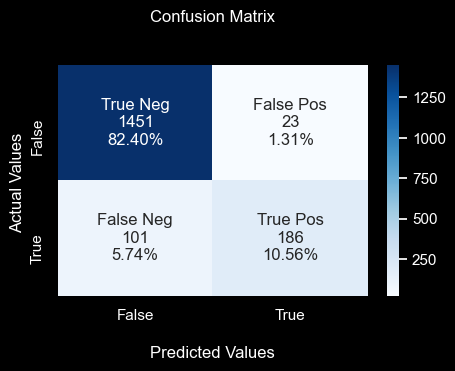

матрица ошибок тестовая выборка только важные фичи с оптимальным порогом


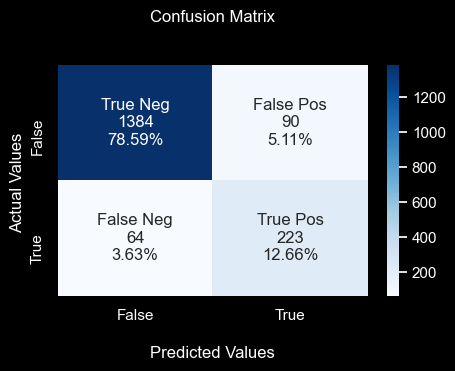

In [181]:
print('матрица ошибок тестовая выборка только важные фичи')
c_matrix(target_test, pred_imp)
print('матрица ошибок тестовая выборка только важные фичи с оптимальным порогом')
c_matrix(target_test, calibrated_pred_imp)

Отбор важных признаков немного улучшил метрики, оптимальный порог помог снизить ошибку 2 рода, но снизил точность модели. Выбор модели предлагаю остановить на модели с усеченным количеством признаков или на модели с оптимальным порогом в зависимости от бизнес-задачи 

## Вывод

Данные состоят из файлов, полученных из разных источников:

contract_new.csv — информация о договоре;  
personal_new.csv — персональные данные клиента;   
internet_new.csv — информация об интернет-услугах;  
phone_new.csv — информация об услугах телефонии.  

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


* Данные объединены в один датасет по полю customerID
* Датасет содержит 7043 наблюдения
* Присутствали пропуски, они были обработаны без удаления данных
* Преобразованы типы данных 
* Добавлен таргет exited исходя из того, что у ушедших клиентов проставлена дата EndDate
* Добавлен признак duration в днях, вычисляемый из EndDate минус BeginDate
* Дубликатов датасет не содержит

**Портреты клиентов**
- **Портрет среднестатистического клиента компании**  
Преобладающего гендора у среднестатистического клиента нет, клиент не пенсионер, не имеет иждивенцев, не женат, имеет действующий контракт, оплата производится по безбумажному счету, по электронному чеку, с условием оплаты каждый месяц, в среднем оплата в месяц составляет 65 ед., общие поступления по договору клиента 2100, срок договора 900 дней, клиент использует одну телефонную линию, использует оптиковолоконный кабель, не пользуется услунами: блокировка небезопасных сайтов, облачное хранилище, антивирус, выделенная линия технической поддержки, стриминговое телевидение, каталог фильмов. 

- **Портрет среднестатистического ушедшего клиента компании**  
Ушедший клиент **мужчина**, клиент не пенсионер, не имеет иждивенцев, **женат**, оплата производится по безбумажному счету, по электронному чеку, с условием оплаты каждый месяц, в **среднем оплата в месяц составляет 76** ед., **общие поступления по договору клиента 2300**, **срок договора 925 дней**, **клиент использует несколько телефонных линий**, использует оптиковолоконный кабель, не пользуется услугами: блокировка небезопасных сайтов, выделенная линия технической поддержки, **использует  стриминговое телевидение, каталог фильмов, облачное хранилище**, может использовать антивирус(половина ушедших клиентов использует)  

- **Портрет среднестатистического действующего клиента компании**  
Преобладающего гендора у среднестатистического действующего клиента нет, клиент не пенсионер, не имеет иждивенцев, не женат, оплата производится по безбумажному счету, по электронному чеку, с условием оплаты каждый месяц, в среднем оплата в месяц составляет 63 ед., общие поступления по договору клиента 2000, срок договора 893 дня, клиент использует 1 телефонную линию, использует оптиковолоконный кабель, не пользуется услунами: блокировка небезопасных сайтов, облачное хранилище, антивирус, выделенная линия технической поддержки, стриминговое телевидение, каталог фильмов. 

Ушедший клиент отличается тем, что это скорее всего женатый мужчина со среднемесячной оплатой 76 и общими поступоениями 2300 (что выше, чем у действующего), сроком договора 925 дней(что выше, чем у действующего), он использует несколько телефонных линий, использует стриминговое телевидение, каталог фильмов, облачное хранилище и может использовать антивирус(половина ушедших клиентов использует). 
То есть использует больше услуг и, соответственно, платит больше.

**Динамика притока/оттока клиентов**
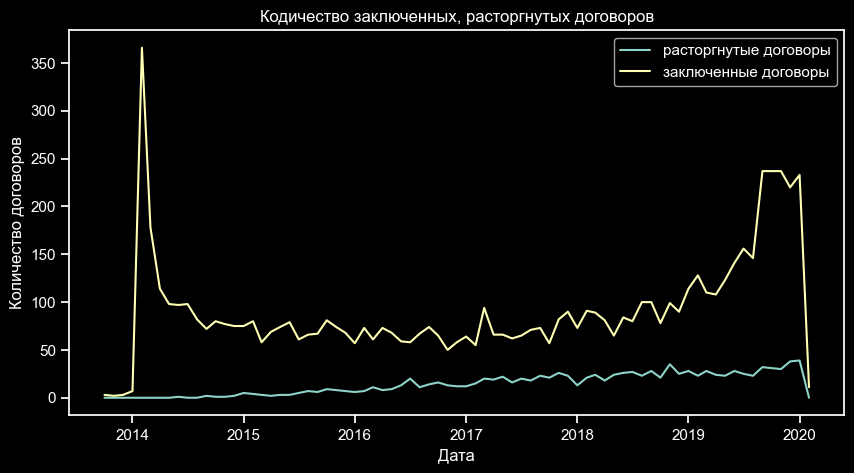
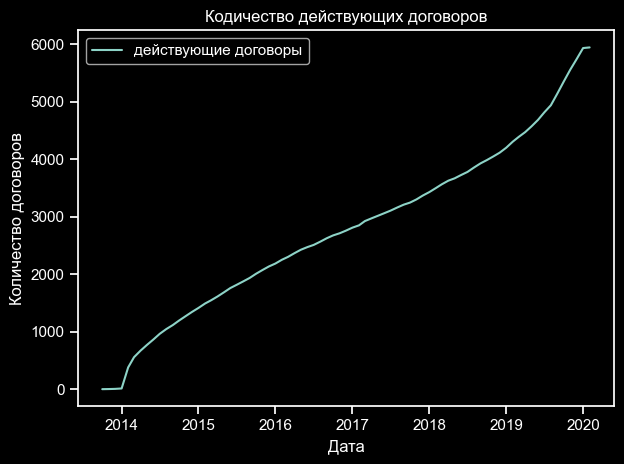
в январе 2020 заключено только 11 договоров, возможно на последнюю дату данные неполные.  
с 2019 наблюдается прирост действующих договоров, в то время как количество расторжений не так заметно растет.   


**Корреляция признаков**
* `type` сильно коррелирует с duration
    * Чем дольше клиент пользуется услугами, тем более долгий срок у типа договора.  
* `monthly_charges` сильно коррелирует с total_charges, internet_service, streaming_t_v, streaming_movies и multiple_lines
    * Чем больше общие поступления от клиента, тем больше его ежемесячный платеж. 
    * Клиенты, использующие оптиковолоконный кабель обычно платят в месяц больше, а те что используют только телефонию платят меньше всего.  
    * Если подключена опция стримингового ТВ, каталога фильмов или вторая линия телефонии - ежемесячная оплата возрастает.
* `total_charges` сильно коррелирует с duration
    * Чем больше срок договора, тем больше его общие поступления.
* `internet_service` сильно коррелирует с multiple_lines
    * клиенты, не использующие телефонию имеют DSL кабель, а те у кого 2 тел.линии используют оптиковолоконный кабель. У клиентов, не использующих интернет обычно 1 телефонная линия
* `streaming_t_v` сильно коррелирует с streaming_movies
    * клиенты, использующие cтриминговое телевидение, также часто использкуют каталог фильмов
        
 

    
Это может создать проблемы мультиколлинеарности при построении  моделей машинного обучения, исправить это можно исключив коррелирующий признак на этапе моделирования. 

Больше всего коррелирует с целевым признаком duration и total_charges


 
* Все модели показали результат лучше случайной модели.
Лучшую метрику ROC-AUC показала модель LightGBM, она также самая быстрая во время обучения. ROC-AUC выше требуемого порога 0.85, модель будет проверена на тестовой выборке
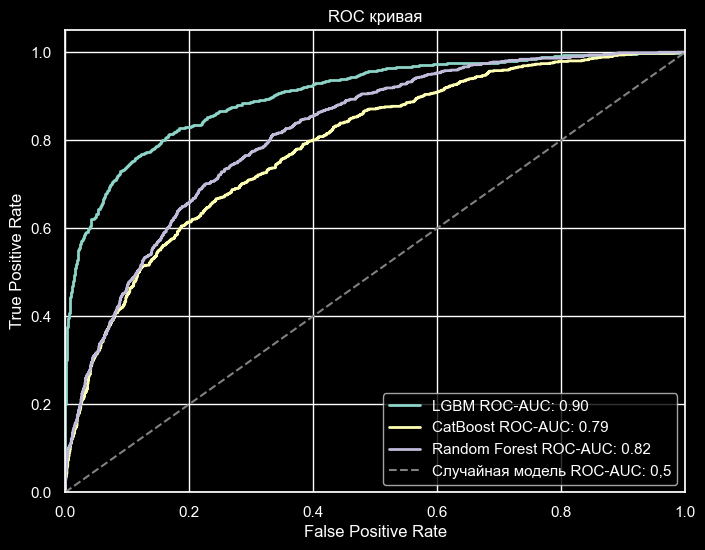

In [84]:
total

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,ROC-AUC
LGBM,1.026274,0.041062,0.052796,0.007111,0.9028
CatBoost,284.316505,7.711004,0.016417,0.000465,0.7867
Random Forest,11.388203,0.093862,0.579459,0.047559,0.8171


**Тестирование модели**  
На тестовой выборке модель показала стабильность и хорошие показатели метрик
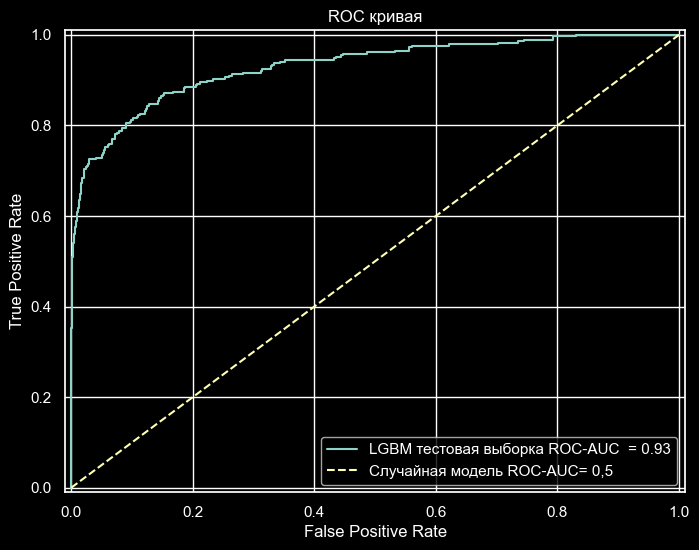



In [85]:
print('ROC-AUC тестовая выборка:', roc_auc_test)
print("Accuracy тестовая выборка:", accuracy)

ROC-AUC тестовая выборка: 0.9305
Accuracy тестовая выборка: 0.929


**Исследование модели**  

модель склонна больше к ошибке 2 рода (пропускать событие). Такая ошибка приводит к потерям ежемесячной оплаты от клиента.   
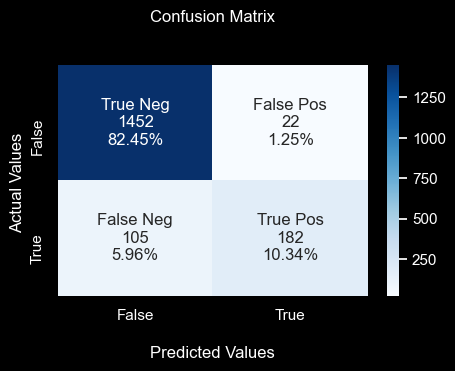

Подобран оптимальный порог с минимальным убытом, при условии что дисконт = 10% от среднемесячной оплаты каждой группы и кол-во клиентов, решивших остаться после спец.предложения 70%

In [86]:
print("оптимальный порог:", optimal_threshold)
print("минимальный убыток:", min_losses)

оптимальный порог: 0.37373737373737376
минимальный убыток: 2085.4285249120244


In [87]:
print("Accuracy тестовая выборка:", accuracy)
print("Accuracy тестовая выборка с оптимальным порогом:", accuracy_calibrated)

Accuracy тестовая выборка: 0.929
Accuracy тестовая выборка с оптимальным порогом: 0.9284497444633731


Общее число правильных ответов с подобранным порогом снизилось, но должно быть меньше ошибки 2 рода. 
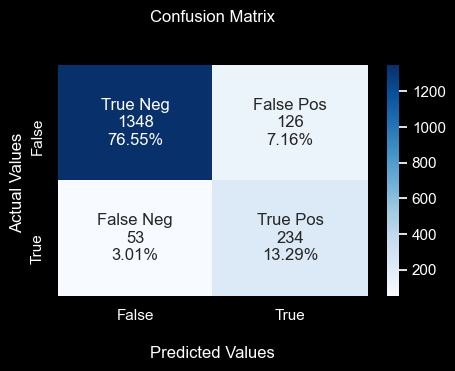

Больше всего важны duration monthly_charges и total_charges
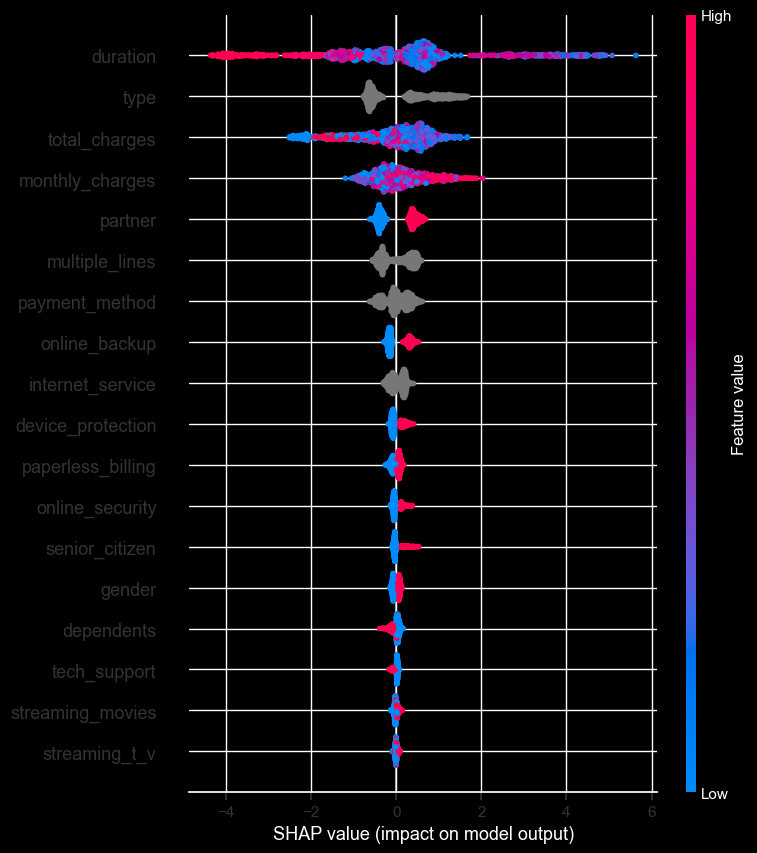
Наименее важные признаки 'streaming_movies', 'streaming_t_v', 'gender', бещ них модель немного улучшила метрики

Подобран оптимальный порог с минимизацией потерь 

In [88]:
print("оптимальный порог:", optimal_threshold_imp)
print("минимальный убыток:", min_losses_imp)

оптимальный порог: 0.27272727272727276
минимальный убыток: 1914.5880509090143


**матрица ошибок тестовая выборка только важные фичи:**
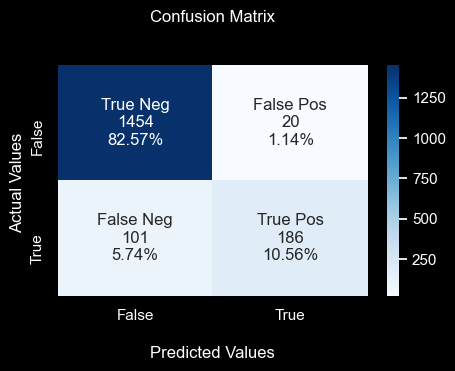

**матрица ошибок тестовая выборка только важные фичи откалиброванная**
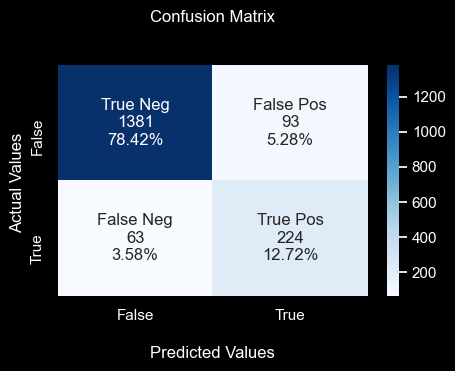

**модель в калибровке не нуждается**
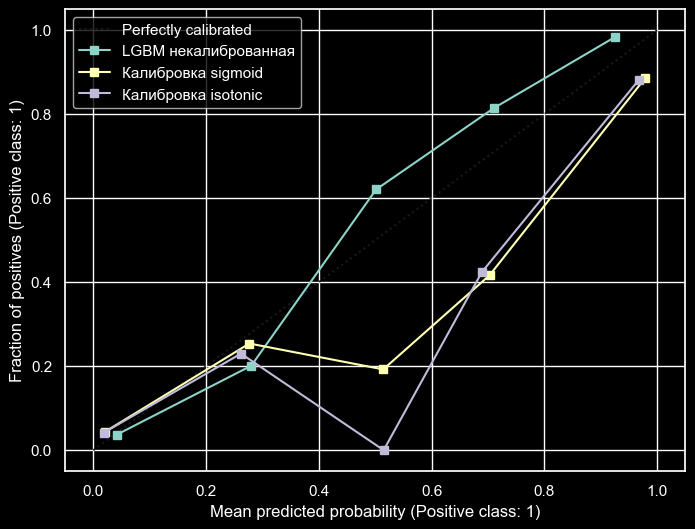

In [89]:
print('ROC-AUC тестовая выборка все фичи:', roc_auc_test)
print('ROC-AUC тестовая выборка только важные фичи:', roc_auc_test_imp)
print("Accuracy тестовая выборка все фичи:", accuracy)
print("Accuracy тестовая выборка только важные фичи:", accuracy_imp)
print("Accuracy тестовая выборка только важные фичи:", accuracy_imp)
print("Accuracy тестовая выборка только важные фичи с оптимальным порогом:", accuracy_calibrated_imp)

ROC-AUC тестовая выборка все фичи: 0.9305
ROC-AUC тестовая выборка только важные фичи: 0.9333
Accuracy тестовая выборка все фичи: 0.929
Accuracy тестовая выборка только важные фичи: 0.933
Accuracy тестовая выборка только важные фичи: 0.933
Accuracy тестовая выборка только важные фичи с оптимальным порогом: 0.9142532651902329


Отбор важных признаков немного улучшил метрики, калибровка помогла снизить ошибку 2 рода, но снизила точность модели. Выбор модели предлагаю остановить либо на модели с усеченным количеством признаков или на откалиброванной модели с усеченным количеством признаков в зависимости от бизнес задачи.


## Отчёт по решению поставленной задачи

### Выполнение плана работ

Работа была проделана согласно поставленному плану, результирующие данные приведены ниже.

1. **Предобработка и разведовательный анализ данных**.  
* были исследованы 4 датасета:   
contract_new.csv — информация о договоре;  
personal_new.csv — персональные данные клиента;  
internet_new.csv — информация об интернет-услугах;  
phone_new.csv — информация об услугах телефонии.  
* Явных дубликатов и дубликатов ID в датасетах не обнаружено.  
* После объединения в один датасет возникли пропуски у клиентов не пользующихся одним из сигментов бизнеса (или отсутствует телефония или интернет).  
Пропуски были обработаны:  
    * 'multiple_lines' клиенты не пользуются телефонией, пропуски заменены на not used
    * 'internet_service' клиенты не пользуются интернетом, пропуски заменены на not used
    * 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies' клиенты не пользуются интернетом, пропуски заменены на No, т.к. уже есть признак not used в переменной internet_service (во избежание мультиколинеарности)
* Удален признак 'customerID'
* Выполнен перевод названий столбцов в snake case
* Значения 'senior_citizen' переведены в категориальные ( 0-No, 1-Yes )
* Преобразованы данные в необходимые форматы:  
    * 'begin_date' в формат даты
    * 'end_date' поставлена заглушка '2020-02-01' вместо 'No', т.к. данные актуальны на эту дату
         * 'end_date' в формат даты
    * 'total_charges' данные на последнюю дату содержали пробел
        * заменены пробелы на значения monthly_charges, т.к. предполагается что клиент заплатит эту сумму
    * 'total_charges' - в тип float   
* Добавлены признаки : 
    * Целевой признак 'exited' на основании даты завершения договора, договоры, закрытые в дату '2020-02-01'(заглушка, поставленная ранее), определяем как не закрытые(0), остальные - закрытые(1)
    * Признак длительности договора в днях 'duration'
* Исследованы боксплоты и гистограммы для всех столбцов датасета  
* Составлены портреты клиента компании:
     * портрет среднестатистического клиента компании 
     * портрет ушедшего клиента
     * портрет действующего клиента
* Составлен график динамики притока/оттока клиентов: 
    * в январе 2020 заключено только 11 договоров, возможно на последнюю дату данные неполные.
    * с 2019 наблюдается прирост действующих договоров, в то время как количество расторжений не так заметно растет. 
    * При этом количество действующих клиентов неизменно растет, отток клиентов не имеет сильного негативного действия на действующий портфель договоров.
* Признаки с датами 'begin_date', 'end_date' удалены, т.к. есть признак длительности договора
* Определение корреляции признаков: 
     * построена корреляционная матрица Phik: 
          *  type сильно коррелирует с duration
          * monthly_charges сильно коррелирует с total_charges, internet_service, streaming_t_v, streaming_movies и multiple_lines
          * total_charges сильно коррелирует с duration 
          * internet_service сильно коррелирует с multiple_lines
          * streaming_t_v сильно коррелирует с streaming_movies
     * построена визуализация коррелирующих признаков: 
          * диаграмма рассеяния коррелирующих числовых переменных 'total_charges', 'monthly_charges':
               * 'duration'- чем больше общие поступления от клиента, тем больше его ежемесячный платеж. и чем больше срок договора, тем больше его общие поступления, что логично. 
     * для категориальных признаков были построены таблицы сопряженности: 
         * клиенты, не использующие телефонию имеют DSL кабель, а те у кого 2 тел.линии используют оптиковолоконный кабель. 
         * У клиентов, не использующих интернет обычно 1 телефонная линия. 
         * клиенты, использующие cтриминговое телевидение, также часто использкуют каталог фильмов 
     * для числовых признаков коррелирующих с категориальными построены боксплоты:
         * Чем дольше клиент пользуется услугами, тем более долгий срок у типа договора.  
         * Клиенты, использующие оптиковолоконный кабель обычно платят в месяц больше, а те что используют только телефонию платят меньше всего.  
        * Если подключена опция стримингового ТВ, каталога фильмов или вторая линия телефонии - ежемесячная оплата возрастает.  
    * Больше всего коррелирует с целевым признаком duration и total_charges



2. **Моделирование**  

* Объекты 'object' переведены в 'category' для пвспознания категориальных признаков моделью LGBM
* Датасет разделен на 2 выборки 75% - train, 25% - test:
    * features_train (5282, 18)
    * features_test (1761, 18)
* Были обучены 3 модели с подбором гиперпараметров с поиском OptunaSearchCV:
    * параметры поиска: 
        * n_trials=50, 
        * cv = 5, 
        * scoring="roc_auc", 
        * timeout=500, 
        * verbose=0, 
        * refit=True



* Модель LightGBM:
     * подбираемые параметры модели: 
        * objective='binary', 
        * random_state=170723
        * 'n_estimators': (4000, 5000),
        * 'learning_rate': (0.001, 0.1),
        * 'max_depth': (2, 50),
        * 'reg_alpha': (0.1, 1, step=0.1),
        * 'reg_lambda': (0.1, 1.0, step=0.1),
        * 'colsample_bytree': (0.1, 1.0, step=0.1),
        * 'num_leaves': (2, 5)
     * лучшие параметры:


In [183]:
search_lgbm.best_params_

{'n_estimators': 4956,
 'learning_rate': 0.073342192490346,
 'max_depth': 31,
 'reg_alpha': 1.0,
 'reg_lambda': 0.2,
 'colsample_bytree': 0.5,
 'num_leaves': 5}

* Модель CatBoost:
     * подбираемые параметры модели:
         * cat_features=categorical, 
         * eval_metric='AUC', 
         * random_state=170723, 
         * verbose=False
         * 'n_estimators': (2500, 3000),
         * 'learning_rate': (0.001, 0.2),
         * 'depth': (5, 16),
         * 'subsample': (0.05, 1.0),
         * 'colsample_bylevel': (0.05, 1.0),
         * 'l2_leaf_reg': (1, 16)
     * лучшие параметры:


In [184]:
search_cat.best_params_

{'n_estimators': 2736,
 'learning_rate': 0.1272466832685437,
 'depth': 12,
 'subsample': 0.10038841639083956,
 'colsample_bylevel': 0.19931595296741988,
 'l2_leaf_reg': 4}


* Модель Random Forest:
    * применен пайплайн: 
         * к категориальным признакам применен OneHotEncoder(handle_unknown='ignore', drop='first')
         * остальные признаки без изменений
    * подбираемые параметры модели:
        * random_state=170723,
        * class_weight='balanced'
        * 'n_estimators': (100, 5000),
        * 'max_depth': (2, 150)
    * лучшие параметры:


In [185]:
search_forest.best_params_

{'model__n_estimators': 3177, 'model__max_depth': 9}

время выполнения и лучшая метрика:

In [186]:
total

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,ROC-AUC
LGBM,1.026274,0.041062,0.052796,0.007111,0.9028
CatBoost,284.316505,7.711004,0.016417,0.000465,0.7867
Random Forest,11.388203,0.093862,0.579459,0.047559,0.8171


* По результатам моделирования была выбрана модель LightGBM


3. **Тестирование**
* Результаты тестирования LightGBM :
 


In [187]:
print('ROC-AUC тестовая выборка:', roc_auc_test)
print("Accuracy тестовая выборка:", accuracy)

ROC-AUC тестовая выборка: 0.9305
Accuracy тестовая выборка: 0.929



* Модель пригодна для использования, метрика ROC-AUC превосходит требуемый порог в 0.85, также модель прошла проверку на вменяемость (ROC-AUC>0.5)

4. **Исследование модели**  
* Построена матрица ошибок:
    * модель склонна больше к ошибке 2 рода (пропускать событие). Такая ошибка приводит к потерям ежемесячной оплаты от клиента.
* Подобран оптимальный порог и рассчитан минимальный убыток с учетом предполагаемого дисконта и кол-ва клиентов, решивших остаться после спец.предложения - 70%:


In [188]:
print("оптимальный порог:", optimal_threshold)
print("минимальный убыток:", min_losses)

оптимальный порог: 0.37373737373737376
минимальный убыток: 2085.4285249120244


* Выполнена калибровка, однако для модели это не пошло на пользу
* Исследованы выжные для модели признаки: 
    * построен shap.summary_plot
    * 'streaming_t_v', 'streaming_movies' и 'gender' не привносили вклад в обучение модели
    * осуществлен подбор гиперпараметров через поиск OptunaSearchCV и обучение модели LGBM на данных исклбчающих признаки 'streaming_t_v', 'streaming_movies' и 'gender' 
    * лучшие параметры:
    

In [189]:
search_lgbm_i.best_params_

{'n_estimators': 4783,
 'learning_rate': 0.0670463152130009,
 'max_depth': 48,
 'reg_alpha': 1.0,
 'reg_lambda': 0.1,
 'colsample_bytree': 0.4,
 'num_leaves': 4}

In [190]:
print('ROC-AUC тестовая выборка все фичи:', roc_auc_test)
print('ROC-AUC тестовая выборка только важные фичи:', roc_auc_test_imp)

print("Accuracy тестовая выборка все фичи:", accuracy)
print("Accuracy тестовая выборка только важные фичи:", accuracy_imp)

ROC-AUC тестовая выборка все фичи: 0.9305
ROC-AUC тестовая выборка только важные фичи: 0.9319
Accuracy тестовая выборка все фичи: 0.929
Accuracy тестовая выборка только важные фичи: 0.9296


Метрики немного улучшились

* подобран оптимальный порог и рассчитан минимальный убыток с учетом предполагаемого дисконта и кол-ва клиентов, решивших остаться после спец.предложения - 70%:


In [192]:
print("оптимальный порог:", optimal_threshold_imp)
print("минимальный убыток:", min_losses_imp)


оптимальный порог: 0.2828282828282829
минимальный убыток: 2015.354365345479


Почти все пункты изначального плана выполнены кроме масштабирования, т.к. были использованы нелинейные модели.

### Возникшие трудности

На мой взгляд, модель точнее справилась бы с задачей, если была предоставлена информация о наименовании и условиях тарифов, однако и без этих данных, сгенерировав признак длительности договоров в днях удалось получить стабильную модель со значением метрики выше требуемой.

###  Ключевые шаги

Ключевыми шагами в решении задачи могу выделить предобработку данных, моделирование как минимум на 3х моделях с широким диапазоном подбираемых гиперпараметров, избежание утечки данных, получение как можно более высокой метрики ROC-AUC для поставленной зададачи

### Признаки, использованные для обучения

* при первом обучении моделей были использованы признаки:  
    * численные признаки 'monthly_charges', 'total_charges', 'duration'
    * категориальные признаки 'type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines'
* после анализа важности признаков были исключены признаки, не вносящие вклад в предсказания: 
    * 'streaming_t_v', 'streaming_movies' и 'gender'
* метрики немного улучшились после исключения ненужных признаков.

### Итоговая модель

Итоговоая модель - LightGBM.   
Гиперпараметры:

In [195]:
search_lgbm_i.best_params_

{'n_estimators': 4783,
 'learning_rate': 0.0670463152130009,
 'max_depth': 48,
 'reg_alpha': 1.0,
 'reg_lambda': 0.1,
 'colsample_bytree': 0.4,
 'num_leaves': 4}

Метрики качества:

In [196]:
print('ROC-AUC тестовая выборка только важные фичи:', roc_auc_test_imp)
print("Accuracy тестовая выборка только важные фичи:", accuracy_imp)

ROC-AUC тестовая выборка только важные фичи: 0.9319
Accuracy тестовая выборка только важные фичи: 0.9296
